# Predicting credit card default

In addition to the standard packages required to BENG0095, imblearn and and pytorch have been used in this notebook.

## Introduction
This assignment prompts the students to examine credit card default prediction with data taken from the 'Default of Credit Card Clients' Data Set taken from the UCI Machine Learning Repository.

In [107]:
#Importing packages used in notebook.
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import sys
from time import time
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets, ensemble
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import gc
from datetime import datetime
import warnings
warnings.simplefilter('ignore')

## Data Import

Let us import the training and test data and concatenate them to work on the whole data set in general as this will ensure the data can be scaled and manipulated without the possibility of bias to the train or test set.

In [108]:
df_train = pd.read_csv(r'C:\Users\Tom\Documents\GitHub\groupL\CreditCard_train.csv',skiprows=1)
df_test = pd.read_csv(r'C:\Users\Tom\Documents\GitHub\groupL\CreditCard_test.csv',skiprows=1)
df = pd.concat([df_train, df_test], keys=['train', 'test'])

In [109]:
#Checking the general format(Rows+Columns) of the data
print("Default of credit card clients - rows:",df.shape[0]," columns:", df.shape[1])

Default of credit card clients - rows: 30000  columns: 25


## Data Transformation & Exploration

In [110]:
#Checking for null entries within data set
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30000 entries, ('train', 0) to ('test', 5999)
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-nul

For the sake of completeness, to evidence non-null features,

In [111]:
total = df.isnull().sum().sort_values(ascending = True)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

ID  PAY_AMT5  PAY_AMT4  PAY_AMT3  PAY_AMT2  PAY_AMT1  BILL_AMT6  \
Total    0.0       0.0       0.0       0.0       0.0       0.0        0.0   
Percent  0.0       0.0       0.0       0.0       0.0       0.0        0.0   

         BILL_AMT5  BILL_AMT4  BILL_AMT3  ...  PAY_3  PAY_2  PAY_0  AGE  \
Total          0.0        0.0        0.0  ...    0.0    0.0    0.0  0.0   
Percent        0.0        0.0        0.0  ...    0.0    0.0    0.0  0.0   

         MARRIAGE  EDUCATION  SEX  LIMIT_BAL  PAY_6  \
Total         0.0        0.0  0.0        0.0    0.0   
Percent       0.0        0.0  0.0        0.0    0.0   

         default payment next month  
Total                           0.0  
Percent                         0.0  

[2 rows x 25 columns]

Now, let us analyse if there are duplicates on our training and testing sets and if applicable, drop them. For this, first let us drop the IDs(which have no relavance to the problem at hand) so that we can analyse the duplicates.

In [112]:
df_train = df_train.drop(['ID'], axis=1)
df_test = df_test.drop(['ID'], axis=1)

Now, let us compute how many duplicates are in the data sets.

In [113]:
print(f"There are {df_train.duplicated().sum()} duplicate rows in the training data.")
print(f"There are {df_test.duplicated().sum()} duplicate rows in the test data.")

There are 21 duplicate rows in the training data.
There are 1 duplicate rows in the test data.


Let us proceed with dropping the duplicates. This procedure will only be applied to the training set as it is not necessary for the testing set. Furthermore, only the duplicates are discarded, not their first occurrence.

In [114]:
df_train = df_train.drop_duplicates()

Let us show that this worked,

In [115]:
print("Default of credit card clients (train) - rows:",df_train.shape[0]," columns:", df_train.shape[1])

Default of credit card clients (train) - rows: 23979  columns: 24


In [116]:
#For ease of engineering new features, the training and test sets are linked with keys to allow separation when it comes to model training.
df = pd.concat([df_train, df_test], keys=['train', 'test'])
#and let us show that it worked
print("Default of credit card clients (test) - rows:",df.shape[0]," columns:", df.shape[1])

Default of credit card clients (test) - rows: 29979  columns: 24


Indeed, it worked. Now, for the sake of formality, let us rename two poorly labeled columns.

In [117]:
df = df.rename(columns={'default payment next month': 'default', 
                        'PAY_0': 'PAY_1'})

Now, let us generate descriptive statistics of the data.

In [118]:
df.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    29979.000000  29979.000000  29979.000000  29979.000000  29979.000000   
mean    167461.545749      1.603723      1.853397      1.551853     35.486707   
std     129750.143223      0.489131      0.790410      0.521988      9.218400   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_1         PAY_2         PAY_3         PAY_4         PAY_5  \
count  29979.000000  29979.000000  29979.000000  29979.000000  29979.000000   
mean      -0.016912     -0.132660     -0.165182     -0.219687     -0.265252   
std        1.123658      1.196647      1.196181      1.168463      1.132504   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   29979.000000   29979.000000   29979.000000   29979.000000   
mean   ...   43293.164182   40339.548651   38898.899630    5667.512759   
std    ...   64345.250300   60809.139708   59566.130476   16568.413578   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2342.000000    1776.000000    1261.000000    1000.000000   
50%    ...   19068.000000   18123.000000   17105.000000    2100.000000   
75%    ...   54572.000000   50231.500000   49238.000000    5007.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2       PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  2.997900e+04   29979.000000   29979.000000   29979.000000   
mean   5.925276e+03    5229.307015    4829.422462    4802.714534   
std    2.304841e+04   17612.593758   15671.135211   15283.138185   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    8.390000e+02     390.000000     299.500000     258.000000   
50%    2.010000e+03    1800.000000    1500.000000    1500.000000   
75%    5.000000e+03    4511.000000    4015.000000    4040.000000   
max    1.684259e+06  896040.000000  621000.000000  426529.000000   

            PAY_AMT6       default  
count   29979.000000  29979.000000  
mean     5219.120951      0.221222  
std     17783.164966      0.415076  
min         0.000000      0.000000  
25%       125.000000      0.000000  
50%      1500.000000      0.000000  
75%      4000.000000      0.000000  
max    528666.000000      1.000000  

[8 rows x 24 columns]

The description of the data allows us to discern mislabeled or undocumented categories. First, let us focus on the data transformation & exploration regarding categorical variables i.e. those variables that can take one of a limited number of possible values.

### Categorical variables 
Let us focus first in the features: 'SEX', 'EDUCATION', 'MARRIAGE' and 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' and 'PAY_6'  i.e. X2, X3, X4 and X6-X11 as they are categorical variables. Proceeding to do this, and starting with 'SEX',

In [119]:
df.SEX.value_counts()

2    18099
1    11880
Name: SEX, dtype: int64

<AxesSubplot:>

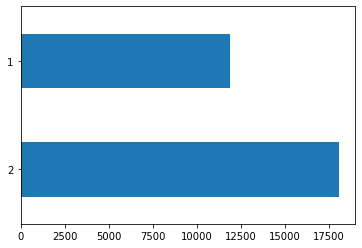

In [120]:
#alternatively, and for the sake of completeness,
df.SEX.value_counts().plot(kind = 'barh')

From the plot, it can be clearly seen that there are no mislabeled or undocumented categories. Also, it can be seen that in the data, more women than men are considered. To visualize their correlation with the target variable i.e. Y, the default outcome of the final predictive model, let us produce the following plot,

<AxesSubplot:ylabel='SEX'>

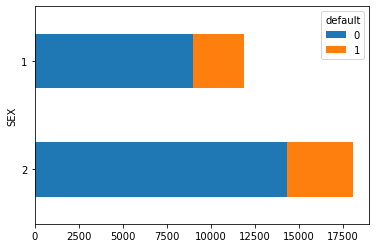

In [121]:
sex_target = pd.crosstab(df.SEX, df.default)
sex_target_plot = sex_target.iloc[::-1] 
sex_target_plot.plot(kind='barh', stacked = True )

Let us now compute the percentage of default for each sex,

In [122]:
sex_target['target_percentage'] = (sex_target[1]/(sex_target[0] + sex_target[1]))
sex_target

default      0     1  target_percentage
SEX                                    
1         9010  2870           0.241582
2        14337  3762           0.207857

From the analysis of the results obtained, it seems reasonable to state that as a primarly intuition, man will be more to default. 

Now, following our analysis with 'EDUCATION',

In [123]:
df.EDUCATION.value_counts()

2    14022
1    10573
3     4916
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

<AxesSubplot:>

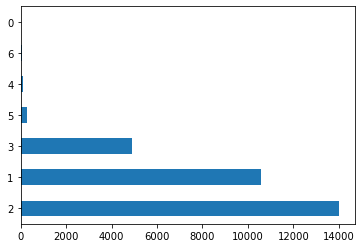

In [124]:
#alternatively, and for the sake of completeness,
df.EDUCATION.value_counts().plot(kind = 'barh')

From the plot, it can be clearly seen that there are mislabeled categories. Concretely, there are 280 entries as 5, 51 as 6 and 14 as 0. By analysing the education labels, we can see that these should belong to the 4th category i.e. 'others'. Let us do this,

In [125]:
edu_clean = (df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6)
df.loc[edu_clean, 'EDUCATION'] = 4

Let us show that this worked,

In [126]:
df.EDUCATION.value_counts()

2    14022
1    10573
3     4916
4      468
Name: EDUCATION, dtype: int64

Indeed, it worked since 468 are the total of entries in categories 0, 4, 5 and 6 from the training data set. Similarly as before, to visualize their correlation with the target variable i.e. Y, the default outcome of the final predictive model, let us produce the following plot,

<AxesSubplot:ylabel='EDUCATION'>

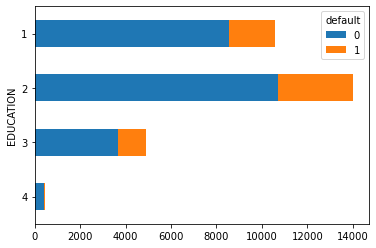

In [127]:
edu_target = pd.crosstab(df.EDUCATION, df.default)
edu_target_plot = edu_target.iloc[::-1] 
edu_target_plot.plot(kind='barh', stacked = True )

and, again, computing the percentage of default for each education category, 

In [128]:
edu_target['target_percentage'] = (edu_target[1]/(edu_target[0] + edu_target[1]))
edu_target

default        0     1  target_percentage
EDUCATION                                
1           8539  2034           0.192377
2          10694  3328           0.237341
3           3679  1237           0.251627
4            435    33           0.070513

Therefore, it seems that the lower the education, the higher the probability of defaulting with the exception being the 'Other' category.

Following our analysis now with 'MARRIAGE',

In [129]:
df.MARRIAGE.value_counts()

2    15952
1    13650
3      323
0       54
Name: MARRIAGE, dtype: int64

<AxesSubplot:>

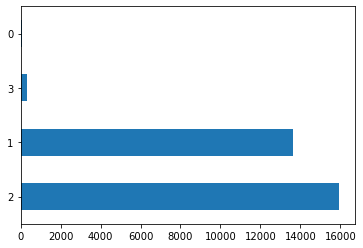

In [130]:
#alternatively, and for the sake of completeness,
df.MARRIAGE.value_counts().plot(kind = 'barh')

From the plot, it can be clearly seen that there are mislabeled categories. Concretely, there are 54 entries as 0. By analysing the marriage labels, we can see that these should belong to the 3rd category i.e. 'others'. Let us do this,

In [131]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

Let us show that this worked,

In [132]:
df.MARRIAGE.value_counts()

2    15952
1    13650
3      377
Name: MARRIAGE, dtype: int64

Indeed, it worked since 377 are the total of entries in categories 0 and 3 from the training data set. Similarly as before, to visualize their correlation with the target variable i.e. Y, the default outcome of the final predictive model, let us produce the following plot,

<AxesSubplot:ylabel='MARRIAGE'>

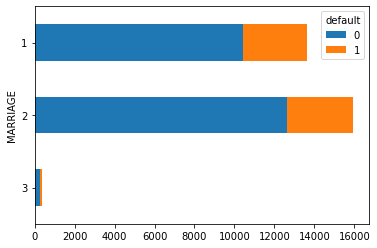

In [133]:
marriage_target = pd.crosstab(df.MARRIAGE, df.default)
marriage_target_plot = marriage_target.iloc[::-1] 
marriage_target_plot.plot(kind='barh', stacked = True )

and, again, computing the percentage of default for each marriage category,

In [134]:
marriage_target['target_percentage'] = (marriage_target[1]/(marriage_target[0] + marriage_target[1]))
marriage_target

default       0     1  target_percentage
MARRIAGE                                
1         10447  3203           0.234652
2         12612  3340           0.209378
3           288    89           0.236074

Therefore, it seems that married people are more likely to default, along with 'others' which from now one we will picture as divorced, for intuitive purposes. Note at this point that the 'others' cathegories might be difficult to interpret and further analysis might be required.

Finally, let us follow our analysis with the 'PAY_n' features, where n={1, 2, 3, 4, 5, 6}. Thus, proceeding to do this, 

In [135]:
PAY_n = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

PAY_n_counts = [
    df.PAY_1.value_counts(),
    df.PAY_2.value_counts(),
    df.PAY_3.value_counts(),
    df.PAY_4.value_counts(),
    df.PAY_5.value_counts(),
    df.PAY_6.value_counts(),
    ]
pd.DataFrame(PAY_n_counts)

-2      -1        0       1       2      3     4     5     6     7  \
PAY_1  2755.0  5684.0  14737.0  3674.0  2666.0  322.0  76.0  26.0  11.0   9.0   
PAY_2  3764.0  6048.0  15730.0    28.0  3926.0  326.0  99.0  25.0  12.0  20.0   
PAY_3  4067.0  5936.0  15764.0     4.0  3819.0  240.0  75.0  21.0  23.0  27.0   
PAY_4  4330.0  5685.0  16455.0     2.0  3159.0  180.0  68.0  35.0   5.0  58.0   
PAY_5  4528.0  5537.0  16947.0     NaN  2626.0  178.0  83.0  17.0   4.0  58.0   
PAY_6  4877.0  5738.0  16286.0     NaN  2766.0  184.0  48.0  13.0  19.0  46.0   

          8  
PAY_1  19.0  
PAY_2   1.0  
PAY_3   3.0  
PAY_4   2.0  
PAY_5   1.0  
PAY_6   2.0

In [136]:
#alternatively, and for the sake of completeness,
#first, let us define a function to plot the corresponding bar charts,
def barcharts_plot(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate (variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        data_bar  = df[var_name].value_counts()
        ax.bar(data_bar.index, data_bar)
        ax.set_title(var_name)                
    fig.tight_layout()
    plt.show()

Thus, applying it to PAY_n,

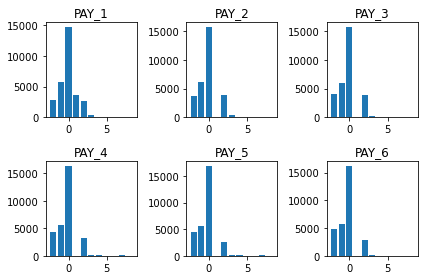

In [137]:
 barcharts_plot(PAY_n, PAY_n.columns, 2, 3)

From the plots above, we can see that there are entries corresponding -2 and 0. These are not documented and, therefore, have to be adjusted. Due to the significance of the documented entries, it seems reasonable to classify them within as 'pay duly'. Moreover, for the sake of formality, 'pay duly' comprising -2, -1 and 0 will be adjusted as 0, 'pay duly'. Proceeding to do this,

In [138]:
for i in PAY_n:
    PAY_n_clean = (df[i] == -2) | (df[i] == -1) | (df[i] == 0)
    df.loc[PAY_n_clean, i] = 0

Let us show that this worked,

In [139]:
PAY_n_counts = [
    df.PAY_1.value_counts(),
    df.PAY_2.value_counts(),
    df.PAY_3.value_counts(),
    df.PAY_4.value_counts(),
    df.PAY_5.value_counts(),
    df.PAY_6.value_counts(),
    ]
pd.DataFrame(PAY_n_counts)

0       1       2      3     4     5     6     7     8
PAY_1  23176.0  3674.0  2666.0  322.0  76.0  26.0  11.0   9.0  19.0
PAY_2  25542.0    28.0  3926.0  326.0  99.0  25.0  12.0  20.0   1.0
PAY_3  25767.0     4.0  3819.0  240.0  75.0  21.0  23.0  27.0   3.0
PAY_4  26470.0     2.0  3159.0  180.0  68.0  35.0   5.0  58.0   2.0
PAY_5  27012.0     NaN  2626.0  178.0  83.0  17.0   4.0  58.0   1.0
PAY_6  26901.0     NaN  2766.0  184.0  48.0  13.0  19.0  46.0   2.0

Indeed, it worked since there are no more -2 or -1 entries. Similarly as before, to visualize their correlation with the target variable i.e. Y, the default outcome of the final predictive model, let us produce the following plot,

In [140]:
#first, let us create a function to plot this,
def barcharts2_plot(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate (variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        data_bar  = df[var_name][(df['default']==0)].value_counts()
        data_bar2  = df[var_name][(df['default']==1)].value_counts()
        ax.bar(data_bar.index, data_bar)
        ax.bar(data_bar2.index, data_bar2)
        ax.set_title(var_name) 
        ax.legend(['0', '1'], loc='upper right')
    fig.tight_layout()
    plt.show()

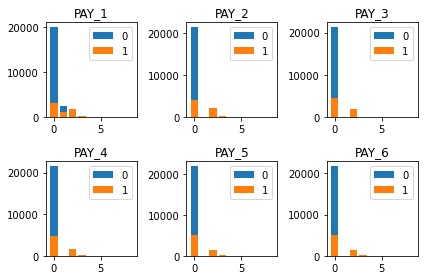

In [141]:
PAY_n_target = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default']]
barcharts2_plot(PAY_n_target, PAY_n.columns, 2, 3)

and, again, computing the percentage of default for each history of past payment category,

In [142]:
#Calculating default percentage for each past payment category
PAY_1_target = pd.crosstab(df.PAY_1, df.default)
PAY_1_target['target_percentage'] = (PAY_1_target[1]/(PAY_1_target[0] + PAY_1_target[1]))

PAY_2_target = pd.crosstab(df.PAY_2, df.default)
PAY_2_target['target_percentage'] = (PAY_2_target[1]/(PAY_2_target[0] + PAY_2_target[1]))

PAY_3_target = pd.crosstab(df.PAY_3, df.default)
PAY_3_target['target_percentage'] = (PAY_3_target[1]/(PAY_3_target[0] + PAY_3_target[1]))

PAY_4_target = pd.crosstab(df.PAY_4, df.default)
PAY_4_target['target_percentage'] = (PAY_4_target[1]/(PAY_4_target[0] + PAY_4_target[1]))

PAY_5_target = pd.crosstab(df.PAY_5, df.default)
PAY_5_target['target_percentage'] = (PAY_5_target[1]/(PAY_5_target[0] + PAY_5_target[1]))

PAY_6_target = pd.crosstab(df.PAY_6, df.default)
PAY_6_target['target_percentage'] = (PAY_6_target[1]/(PAY_6_target[0] + PAY_6_target[1]))

In [143]:
#Tabulating default percentages
PAY_n_target_prctg1 = pd.concat([PAY_1_target, PAY_2_target], axis=1)
PAY_n_target_prctg2 = pd.concat([PAY_n_target_prctg1 , PAY_3_target], axis=1)
PAY_n_target_prctg3 = pd.concat([PAY_n_target_prctg2 , PAY_4_target], axis=1)
PAY_n_target_prctg4 = pd.concat([PAY_n_target_prctg3 , PAY_5_target], axis=1)
PAY_n_target_prctg = pd.concat([PAY_n_target_prctg4 , PAY_6_target], axis=1)
PAY_n_target_prctg.columns = ['PAY 1 (0)', 'PAY 1 (1)', 'PAY 1 (target_percentage)', 'PAY 2 (0)', 'PAY 2 (1)', 'PAY 2 (target_percentage)', 'PAY 3 (0)', 'PAY 3 (1)', 'PAY 3 (target_percentage)', 'PAY 4 (0)', 'PAY 4 (1)', 'PAY 4 (target_percentage)', 'PAY 5 (0)', 'PAY 5 (1)', 'PAY 5 (target_percentage)', 'PAY 6 (0)', 'PAY 6 (1)', 'PAY 6 (target_percentage)'] 
PAY_n_target_prctg

PAY 1 (0)  PAY 1 (1)  PAY 1 (target_percentage)  PAY 2 (0)  PAY 2 (1)  \
0      19969       3207                   0.138376      21385       4157   
1       2425       1249                   0.339956         23          5   
2        823       1843                   0.691298       1743       2183   
3         78        244                   0.757764        125        201   
4         24         52                   0.684211         49         50   
5         13         13                   0.500000         10         15   
6          5          6                   0.545455          3          9   
7          2          7                   0.777778          8         12   
8          8         11                   0.578947          1          0   

   PAY 2 (target_percentage)  PAY 3 (0)  PAY 3 (1)  PAY 3 (target_percentage)  \
0                   0.162752      21336       4431                   0.171964   
1                   0.178571          3          1                   0.250000   
2                   0.556037       1850       1969                   0.515580   
3                   0.616564        102        138                   0.575000   
4                   0.505051         32         43                   0.573333   
5                   0.600000          9         12                   0.571429   
6                   0.750000          9         14                   0.608696   
7                   0.600000          5         22                   0.814815   
8                   0.000000          1          2                   0.666667   

   PAY 4 (0)  PAY 4 (1)  PAY 4 (target_percentage)  PAY 5 (0)  PAY 5 (1)  \
0      21716       4754                   0.179600    22028.0     4984.0   
1          1          1                   0.500000        NaN        NaN   
2       1506       1653                   0.523267     1203.0     1423.0   
3         70        110                   0.611111       65.0      113.0   
4         23         45                   0.661765       33.0       50.0   
5         17         18                   0.514286        7.0       10.0   
6          3          2                   0.400000        1.0        3.0   
7         10         48                   0.827586       10.0       48.0   
8          1          1                   0.500000        0.0        1.0   

   PAY 5 (target_percentage)  PAY 6 (0)  PAY 6 (1)  PAY 6 (target_percentage)  
0                   0.184511    21879.0     5022.0                   0.186685  
1                        NaN        NaN        NaN                        NaN  
2                   0.541889     1365.0     1401.0                   0.506508  
3                   0.634831       66.0      118.0                   0.641304  
4                   0.602410       18.0       30.0                   0.625000  
5                   0.588235        6.0        7.0                   0.538462  
6                   0.750000        5.0       14.0                   0.736842  
7                   0.827586        8.0       38.0                   0.826087  
8                   1.000000        0.0        2.0                   1.000000

From the results obtained, it seems that default is more likely as payments are delayed, as it can be intuitively foreseen. Having now cleaned the data provided and to have a more complete picture of the impact of the different variables, let us visualise now the effect of continuous variables.

### Continuous variables 

To do this, let us produce some useful plots comprising the features 'LIMIT_BAL', 'AGE', 'BILL_AMT_n' and 'PAY_AMT_n' i.e. X5, X12-X17 and X18-X23. Proceeding to do this, and starting with 'LIMIT_BAL'

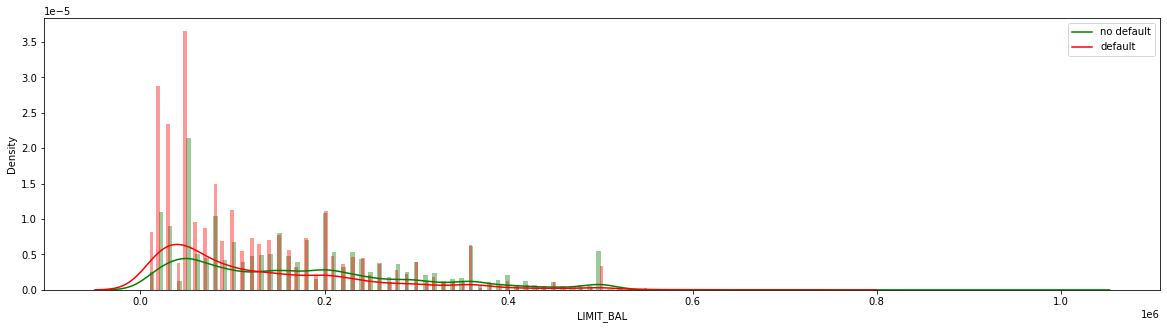

In [144]:
no_def_lbal = df.loc[df.default == 0, 'LIMIT_BAL']
def_lbal =  df.loc[df.default == 1, 'LIMIT_BAL']
plt.figure(figsize=(20, 5))
sns.distplot(no_def_lbal, bins=200, color='green')
sns.distplot(def_lbal, bins=200, color='red')
plt.legend(labels=['no default', 'default'])
plt.show()

From the plot above, it can be seen that most defaults are within the range of 0-100,000. From that point onwards, it seems that the larger the amount of given credit, the less likely to default. Also, it shall be noted that the larger number of default are for the amount of 20000, 30000 and 50000.

Following our analysis now with 'AGE'

In [145]:
#first, let us create a function to plot this,
def hist2_plot(df, variables, n_rows, n_cols,):
    fig=plt.figure(figsize=(15, 5))
    for i, var_name in enumerate (variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        data_hist = df[var_name][(df['default']==0)]
        data_hist2 = df[var_name][(df['default']==1)]
        data_hist.hist(bins=58)
        data_hist2.hist(bins=58)
        ax.set_title(var_name) 
        ax.legend(['0', '1'], loc='upper right')
    fig.tight_layout()
    plt.show()

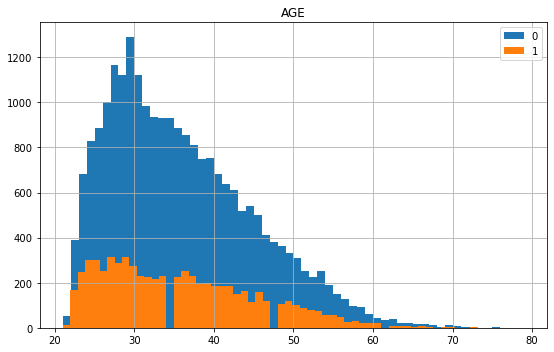

In [146]:
age_target = df[['AGE', 'default']]
age2=df[['AGE']]
hist2_plot(age_target, age2.columns, 1, 2)

Alternatively,

<AxesSubplot:xlabel='default', ylabel='AGE'>

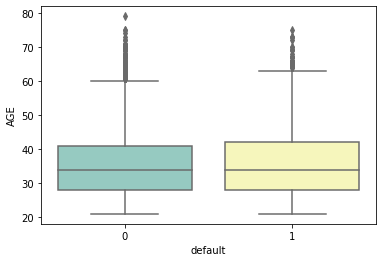

In [147]:
sns.boxplot(x='default', y='AGE', data=df, palette="Set3")

Following our analysis now with 'BILL_AMT_n',

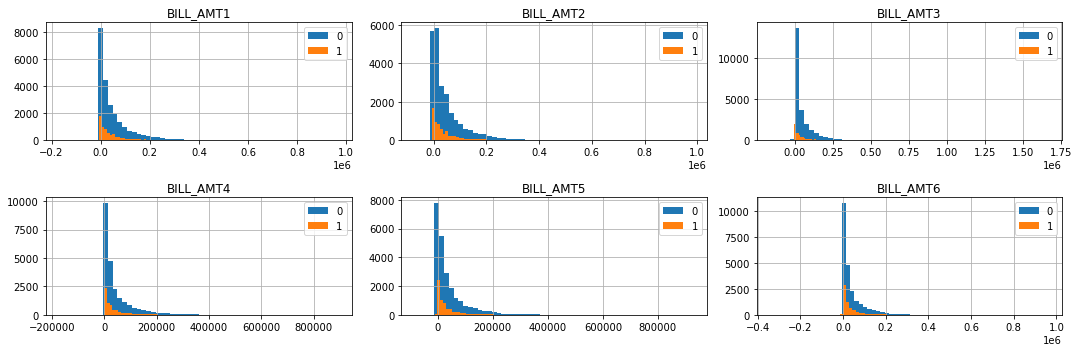

In [148]:
BILL_AMT_n = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
bill_amt_target = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'default']]
hist2_plot(bill_amt_target, BILL_AMT_n.columns, 2, 3)

From the plots above and the description of the 'BILL_AMT_n', it can be seen that in some cases it seems that the clients overpaid since the bill statement is negative. This, seems to mean that credit has to be given to them, but this event likely has the same impact as if they pay duly. Therefore, in these cases, the negative values will be considered to be paid i.e. 0. Thus,

In [149]:
for i in BILL_AMT_n :
    BILL_AMT_n_clean = (df[i] < 0)
    df.loc[BILL_AMT_n_clean, i] = 0

Let us check that this worked,

In [150]:
BILL_AMT_12_descr = pd.concat([df[['BILL_AMT1']].describe(),df[['BILL_AMT2']].describe()], axis=1)
BILL_AMT_123_descr = pd.concat([BILL_AMT_12_descr ,df[['BILL_AMT3']].describe()], axis=1)
BILL_AMT_1234_descr = pd.concat([BILL_AMT_123_descr ,df[['BILL_AMT4']].describe()], axis=1)
BILL_AMT_12345_descr = pd.concat([BILL_AMT_1234_descr ,df[['BILL_AMT5']].describe()], axis=1)
BILL_AMT_123456_descr = pd.concat([BILL_AMT_12345_descr ,df[['BILL_AMT6']].describe()], axis=1)
BILL_AMT_123456_descr

BILL_AMT1      BILL_AMT2     BILL_AMT3      BILL_AMT4  \
count   29979.000000   29979.000000  2.997900e+04   29979.000000   
mean    51281.849194   49240.896661  4.707803e+04   43329.892858   
std     73621.366514   71163.798311  6.933193e+04   64307.326131   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%      3580.000000    3000.000000  2.693500e+03    2342.000000   
50%     22415.000000   21246.000000  2.011100e+04   19068.000000   
75%     67208.500000   64057.000000  6.018650e+04   54572.000000   
max    964511.000000  983931.000000  1.664089e+06  891586.000000   

           BILL_AMT5      BILL_AMT6  
count   29979.000000   29979.000000  
mean    40375.264785   38969.457387  
std     60778.571743   59457.907572  
min         0.000000       0.000000  
25%      1776.000000    1261.000000  
50%     18123.000000   17105.000000  
75%     50231.500000   49238.000000  
max    927171.000000  961664.000000

and, finally, with 'PAY_AMT_n',

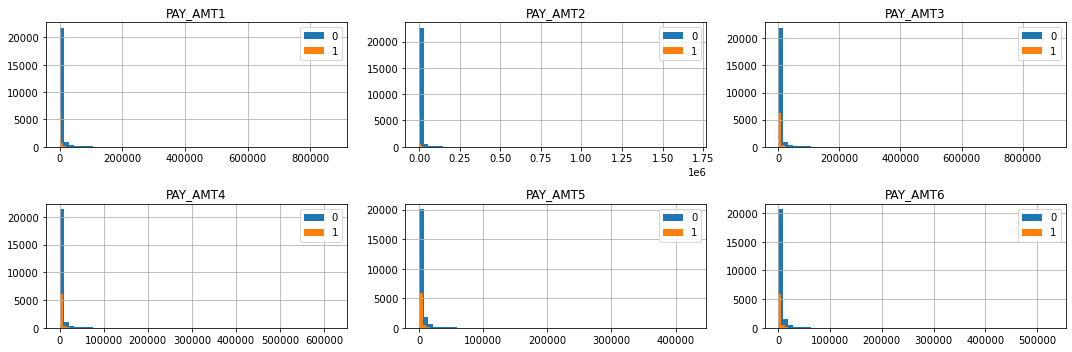

In [151]:
PAY_AMT_n = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
pay_amt_target = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default']]
hist2_plot(pay_amt_target, PAY_AMT_n.columns, 2, 3)

Now, having fully cleaned the data, let us visualise some interesting plots which might give some useful intuition to consider when proceeding with feature engineering.

#### Data visualisation

Prior to feature engineering, let us visualise the effect of different variables on default as this will allow us to untuitively understand better the relations between the variables and their significance.

Firstly, to check the data unbalance with respect to the target value,

<AxesSubplot:>

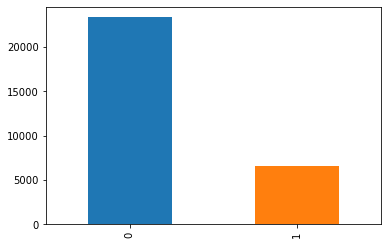

In [152]:
default_tot_count = df['default'].value_counts()
default_tot_count.plot.bar(color = ['C0', 'C1'])

<AxesSubplot:xlabel='AGE', ylabel='LIMIT_BAL'>

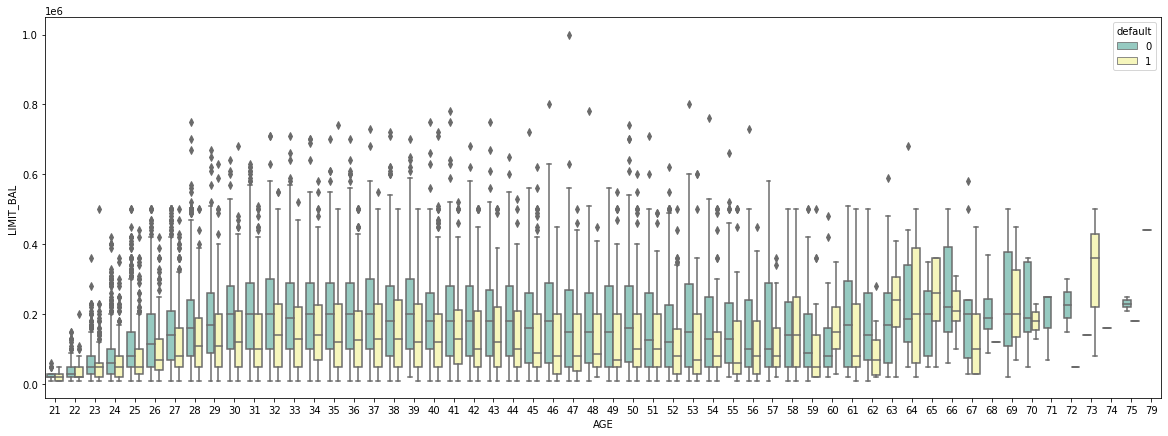

In [153]:
plt.figure(figsize=(20,7))
sns.boxplot(x='AGE', y='LIMIT_BAL', hue= 'default', data=df, palette="Set3")

<AxesSubplot:xlabel='MARRIAGE', ylabel='AGE'>

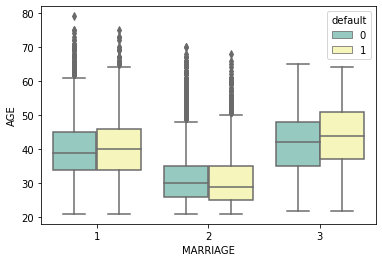

In [154]:
sns.boxplot(x='MARRIAGE', y='AGE', hue= 'default', data=df, palette="Set3")

<AxesSubplot:xlabel='EDUCATION', ylabel='LIMIT_BAL'>

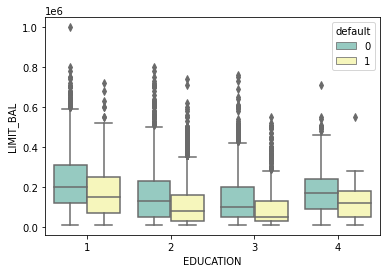

In [155]:
sns.boxplot(x='EDUCATION', y='LIMIT_BAL', hue= 'default', data=df, palette="Set3")

The plot above suggest that customers with higher education levels get higher credit limtis.

<AxesSubplot:xlabel='MARRIAGE', ylabel='LIMIT_BAL'>

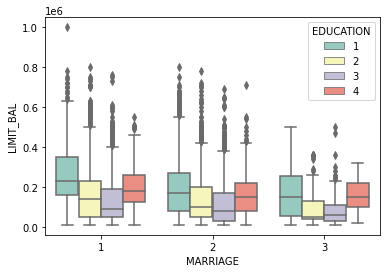

In [156]:
sns.boxplot(x='MARRIAGE', y='LIMIT_BAL', hue= 'EDUCATION', data=df, palette="Set3")

Prior to feature engineering, a representation that might be useful to discern some correlations between the features,

<AxesSubplot:>

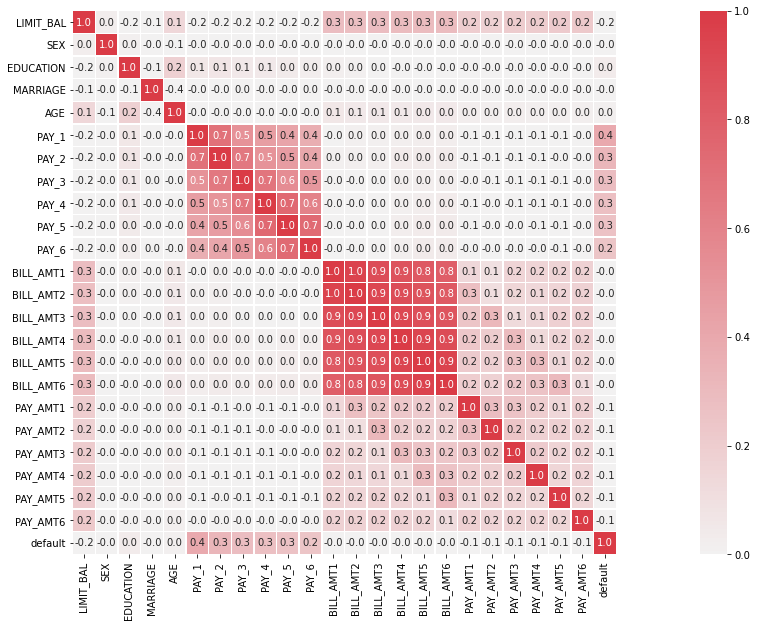

In [157]:
corr = df.corr()
from seaborn import heatmap
plt.subplots(figsize=(30, 10))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=0, vmax=1, center=0,
    square=True, linewidths=0.5,  annot=True, fmt=".1f" )

## Methodology overview

### Feature engineering

To evalaute correctly and improve the performance of algorithms we shall capture some underlying connections between the features. For this, let us use some feature engineering strategies with the aim to make the features more significant for the classifier or to create additional features in order to enrich transaction data.

A first new feature to consider is the following ratio,
$$
\textrm{Bill credit ratio}=\frac{\textrm{Amount billed}}{\textrm{Amount of the given credit}}
$$
as this will allow us to capture the relation between the bill and its distance with the amount of credit given and, ultimately, see its relation with default.

In [158]:
df['Bill_credit_ratio1'] = (df.LIMIT_BAL - df.BILL_AMT1) / (df.LIMIT_BAL)
df['Bill_credit_ratio2'] = (df.LIMIT_BAL - df.BILL_AMT2) / (df.LIMIT_BAL)
df['Bill_credit_ratio3'] = (df.LIMIT_BAL - df.BILL_AMT3) / (df.LIMIT_BAL)
df['Bill_credit_ratio4'] = (df.LIMIT_BAL - df.BILL_AMT4) / (df.LIMIT_BAL)
df['Bill_credit_ratio5'] = (df.LIMIT_BAL - df.BILL_AMT5) / (df.LIMIT_BAL)
df['Bill_credit_ratio6'] = (df.LIMIT_BAL - df.BILL_AMT6) / (df.LIMIT_BAL)

df[['Bill_credit_ratio1', 'Bill_credit_ratio2', 'Bill_credit_ratio3', 
    'Bill_credit_ratio4', 'Bill_credit_ratio5', 'Bill_credit_ratio6']]

Bill_credit_ratio1  Bill_credit_ratio2  Bill_credit_ratio3  \
train 0               0.804350            0.844900            0.965550   
      1               0.977650            0.985625            0.977650   
      2               0.675122            0.844144            0.849344   
      3               0.060200            0.035340            0.014180   
      4               0.827660            0.886600            0.283300   
...                        ...                 ...                 ...   
test  5995            0.141145            0.123568            0.052886   
      5996            0.988780            0.987813            0.976653   
      5997            0.881167            0.888133            0.908067   
      5998            1.000000            0.020262            0.046200   
      5999            0.041420            0.021900            0.004720   

            Bill_credit_ratio4  Bill_credit_ratio5  Bill_credit_ratio6  
train 0               1.000000            1.000000            1.000000  
      1               0.972733            0.971208            0.972825  
      2               0.840767            0.833911            0.827233  
      3               0.433720            0.420820            0.409060  
      4               0.581200            0.617080            0.617380  
...                        ...                 ...                 ...  
test  5995            0.599982            0.858014            0.927364  
      5996            0.940140            0.965400            1.000000  
      5997            0.304067            0.313933            0.354767  
      5998            0.340325            0.851812            0.388200  
      5999            0.269300            0.351440            0.693740  

[29979 rows x 6 columns]

Additionally, another feature to consider is the average of the expenses at any given month and examine its distance with the amount of credit given as this will depict the customer behaviour with regards to the default of the payment. Thus, we seek to examine the following ratio,
$$
\textrm{AvgExp credit ratio}=\frac{\textrm{Amount billed} - \textrm{Amount paid}}{\textrm{Amount of the given credit}}
$$

In [159]:
df['AvgExp_credit_ratio1'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) 
                         + (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4']))
                         + (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3']))
                         + (df['BILL_AMT2'] - (df['BILL_AMT3'] - df['PAY_AMT2']))
                         + (df['BILL_AMT1'] - (df['BILL_AMT2'] - df['PAY_AMT1']))) 
                         / 5) / df['LIMIT_BAL']

df['AvgExp_credit_ratio2'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5']))
                         + (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4']))
                         + (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3']))
                         + (df['BILL_AMT2'] - (df['BILL_AMT3'] - df['PAY_AMT2'])))
                         / 4) / df['LIMIT_BAL']

df['AvgExp_credit_ratio3'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) 
                         + (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4']))
                         + (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3'])))
                         / 3) / df['LIMIT_BAL']

df['AvgExp_credit_ratio4'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) 
                         + (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4']))) 
                         / 2) / df['LIMIT_BAL']
df['AvgExp_credit_ratio5'] = ((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5']))) / df['LIMIT_BAL']

df[['AvgExp_credit_ratio1', 'AvgExp_credit_ratio2', 'AvgExp_credit_ratio3', 
    'AvgExp_credit_ratio4', 'AvgExp_credit_ratio5']]

AvgExp_credit_ratio1  AvgExp_credit_ratio2  AvgExp_credit_ratio3  \
train 0                 0.046020              0.047387              0.011483   
      1                 0.004035              0.003050              0.003947   
      2                 0.043796              0.008272              0.003741   
      3                 0.099324              0.120370              0.154087   
      4                 0.191424              0.214545              0.242620   
...                          ...                   ...                   ...   
test  5995              0.195016              0.238506              0.311265   
      5996              0.021564              0.024135              0.028064   
      5997              0.082720              0.101658              0.128900   
      5998              0.241082              0.277850              0.347617   
      5999              0.159696              0.194110              0.252540   

            AvgExp_credit_ratio4  AvgExp_credit_ratio5  
train 0                 0.000000              0.000000  
      1                 0.004213              0.001617  
      2                 0.004344              0.004433  
      3                 0.009360              0.009620  
      4                 0.114980              0.014080  
...                          ...                   ...  
test  5995              0.181980              0.092077  
      5996              0.030360              0.034600  
      5997              0.128683              0.107500  
      5998              0.367000              0.198437  
      5999              0.232220              0.362300  

[29979 rows x 5 columns]

Additionally, another feature to consider are generation categories:
- The Silent Generation: Born 1928-1945 (74-91 years old)
- Baby Boomers: Born 1946-1964 (55-73 years old)
- Generation X: Born 1965-1980 (39-54 years old)
- Millennials: Born 1981-1996 (23-38 years old)
- Generation Z: Born 1997-2012 (7-22 years old)
obtained from: https://www.mentalfloss.com/article/609811/age-ranges-millennials-and-generation-z
However, some of this ranges were relaxed so as to prevent categories with a few entries (e.g. theres a single entry beyond the Silent Generation).

1.0    15168
2.0     6260
0.0     2268
3.0      283
Name: Gen, dtype: int64

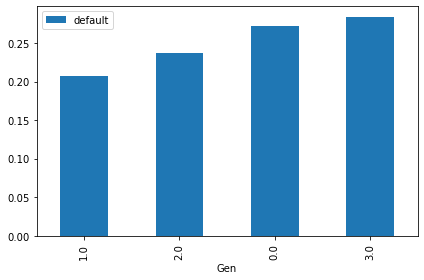

In [160]:
#0 = Millennial 1981-1996, 1 = Generation X 1965-1980, 2 = Baby Boomers 1946-1964, 3 = The Silent Generation born 1945 or before
df.loc[(1981<=2005-df.AGE) & (2005-df.AGE<=1996),'Gen'] = 0
df.loc[(1965<=2005-df.AGE) & (2005-df.AGE<=1980),'Gen'] = 1
df.loc[(1946<=2005-df.AGE) & (2005-df.AGE<=1964),'Gen'] = 2
df.loc[(2005-df.AGE<=1945),'Gen'] = 3
df[['Gen', "default"]].groupby(['Gen']).mean().sort_values(by = 'default').plot(kind = 'bar')
plt.tight_layout()
df.loc['train', :].Gen.value_counts()

4.0    7883
3.0    6988
1.0    4982
0.0    3816
5.0     194
2.0     116
Name: SexMa, dtype: int64

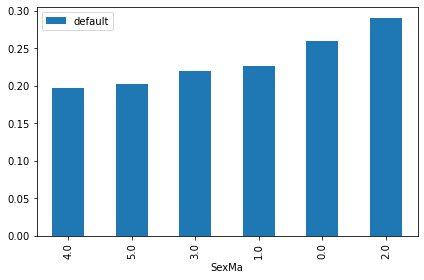

In [161]:
#Sex-Marriage
df.loc[(df.SEX==1)&(df.MARRIAGE==1),'SexMa']=0     #Married man
df.loc[(df.SEX==1)&(df.MARRIAGE==2),'SexMa']=1     #Single man
df.loc[(df.SEX==1)&(df.MARRIAGE==3),'SexMa']=2     #Other man
df.loc[(df.SEX==2)&(df.MARRIAGE==1),'SexMa']=3     #Married woman
df.loc[(df.SEX==2)&(df.MARRIAGE==2),'SexMa']=4     #Single woman
df.loc[(df.SEX==2)&(df.MARRIAGE==3),'SexMa']=5     #Other woman
df[['SexMa', "default"]].groupby(['SexMa']).mean().sort_values(by = 'default').plot(kind = 'bar')
plt.tight_layout()
df.loc['train', :].SexMa.value_counts()

5.0    7292
4.0    5170
1.0    4060
0.0    3261
6.0    2358
2.0    1491
7.0     245
3.0     102
Name: SexEd, dtype: int64

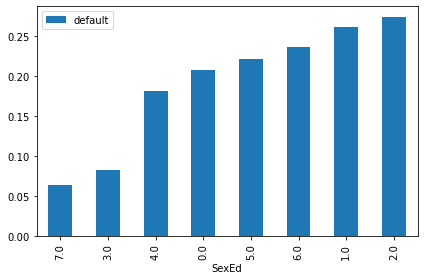

In [162]:
#Sex-Education
df.loc[(df.SEX==1)&(df.EDUCATION==1),'SexEd']=0     #Male graduate
df.loc[(df.SEX==1)&(df.EDUCATION==2),'SexEd']=1     #Male university
df.loc[(df.SEX==1)&(df.EDUCATION==3),'SexEd']=2     #Male high school
df.loc[(df.SEX==1)&(df.EDUCATION==4),'SexEd']=3     #Male other
df.loc[(df.SEX==2)&(df.EDUCATION==1),'SexEd']=4     #Female graduate
df.loc[(df.SEX==2)&(df.EDUCATION==2),'SexEd']=5     #Female university
df.loc[(df.SEX==2)&(df.EDUCATION==3),'SexEd']=6     #Female high school
df.loc[(df.SEX==2)&(df.EDUCATION==4),'SexEd']=7     #Female other
df[['SexEd', "default"]].groupby(['SexEd']).mean().sort_values(by = 'default').plot(kind = 'bar')
plt.tight_layout()
df.loc['train', :].SexEd.value_counts()

5.0    9684
1.0    5484
6.0    3606
2.0    2654
4.0    1640
0.0     628
3.0     148
7.0     135
Name: SexGen, dtype: int64

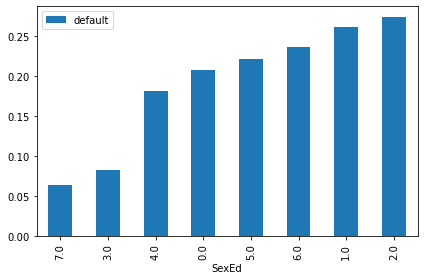

In [163]:
#Sex-Generation
df.loc[(df.SEX==1)&(df.Gen==0),'SexGen']=0     #Male Millennial
df.loc[(df.SEX==1)&(df.Gen==1),'SexGen']=1     #Male Gen X
df.loc[(df.SEX==1)&(df.Gen==2),'SexGen']=2     #Male Boomer
df.loc[(df.SEX==1)&(df.Gen==3),'SexGen']=3     #Male Silent Gen
df.loc[(df.SEX==2)&(df.Gen==0),'SexGen']=4     #Female Millennial
df.loc[(df.SEX==2)&(df.Gen==1),'SexGen']=5     #Female Gen X
df.loc[(df.SEX==2)&(df.Gen==2),'SexGen']=6     #Female Silent Gen
df.loc[(df.SEX==2)&(df.Gen==3),'SexGen']=7     #Female Silent Gen
df[['SexEd', "default"]].groupby(['SexEd']).mean().sort_values(by = 'default').plot(kind = 'bar')
plt.tight_layout()
df.loc['train', :].SexGen.value_counts()

It was reasoned that if, for a particular month, a clients pay, bill or pay amount features are 0, then that client can be said to not be a client for that month.

In [164]:
#Creating Isclient feature
df['Client1']=1
df['Client2']=1
df['Client3']=1
df['Client4']=1
df['Client5']=1
df['Client6']=1
#Filling Isclient feature
df.loc[(df.PAY_1==0)&(df.BILL_AMT1==0)&(df.PAY_AMT1==0),'Client1']=0
df.loc[(df.PAY_2==0)&(df.BILL_AMT2==0)&(df.PAY_AMT2==0),'Client2']=0
df.loc[(df.PAY_3==0)&(df.BILL_AMT3==0)&(df.PAY_AMT3==0),'Client3']=0
df.loc[(df.PAY_4==0)&(df.BILL_AMT4==0)&(df.PAY_AMT4==0),'Client4']=0
df.loc[(df.PAY_5==0)&(df.BILL_AMT5==0)&(df.PAY_AMT5==0),'Client5']=0
df.loc[(df.PAY_6==0)&(df.BILL_AMT6==0)&(df.PAY_AMT6==0),'Client6']=0

To allow the models to take into account the most recent spending habits of the client, the short and long term bill stability features were created, with the short term being the ratio between most recent and second most recent bill whilst the long term uses the mean bill as a reference point. A high value would indicate a larger bill than usual
To account for null values arrising from clients who have all zero bill amounts, said occurrences were set to zero.
Additionally, infinite short term stability (from the second most recent bill being zero) were set to 1 to represent no change (as no information is availiable).

In [165]:
df['Bill_stab_short']=df['BILL_AMT1']/df['BILL_AMT2'] #Short term
df['Bill_stab_long']=df['BILL_AMT1']/df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].mean(axis=1)
df.loc[df.Bill_stab_short.isnull(),'Bill_stab_short']=0 #Accounting for dividing by 0 when all the bills are 0
df.loc[df.Bill_stab_long.isnull(),'Bill_stab_long']=0
df[df[['Bill_stab_short']]==np.inf]=1 #Removing infinite values
df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','Bill_stab_short','Bill_stab_long']]

BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
train 0          3913       3102        689          0          0          0   
      1          2682       1725       2682       3272       3455       3261   
      2         29239      14027      13559      14331      14948      15549   
      3         46990      48233      49291      28314      28959      29547   
      4          8617       5670      35835      20940      19146      19131   
...               ...        ...        ...        ...        ...        ...   
test  5995     188948     192815     208365      88004      31237      15980   
      5996       1683       1828       3502       8979       5190          0   
      5997       3565       3356       2758      20878      20582      19357   
      5998          0      78379      76304      52774      11855      48944   
      5999      47929      48905      49764      36535      32428      15313   

            Bill_stab_short  Bill_stab_long  
train 0            1.261444        3.047508  
      1            1.554783        0.942320  
      2            2.084480        1.725812  
      3            0.974229        1.218757  
      4            1.519753        0.472860  
...                     ...             ...  
test  5995         0.979945        1.562955  
      5996         0.920678        0.476726  
      5997         1.062277        0.303421  
      5998         0.000000        0.000000  
      5999         0.980043        1.245589  

[29979 rows x 8 columns]

Another feature is the payment rate. This measures the percentage of balance a client pays off.
$$
\textrm{PAY_RATn} = \frac{\textrm{PAY_AMTn}}{\textrm{BILL_AMTn}}
$$
From the payment rate, the change of payment rate is:
$$
\textrm{PAY_RAT_VAR1}=\textrm{PAY_RAT1}-\textrm{PAY_RAT2}
$$

In [166]:
#Pay Rate
df['PAY_RAT1']=df['PAY_AMT1']/df['BILL_AMT1']
df['PAY_RAT2']=df['PAY_AMT2']/df['BILL_AMT2']
df['PAY_RAT3']=df['PAY_AMT3']/df['BILL_AMT3']
df['PAY_RAT4']=df['PAY_AMT4']/df['BILL_AMT4']
df['PAY_RAT5']=df['PAY_AMT5']/df['BILL_AMT5']
df['PAY_RAT6']=df['PAY_AMT6']/df['BILL_AMT6']
df[['PAY_RAT1','PAY_RAT2','PAY_RAT3','PAY_RAT4','PAY_RAT5','PAY_RAT6']]=df[['PAY_RAT1','PAY_RAT2','PAY_RAT3','PAY_RAT4','PAY_RAT5','PAY_RAT6']].fillna(0)
df[df[['PAY_RAT1','PAY_RAT2','PAY_RAT3','PAY_RAT4','PAY_RAT5','PAY_RAT6']]==np.inf]=1#Removing infinite values
#Change in payment rate
df['PAY_RAT_VAR1']=df['PAY_RAT1']-df['PAY_RAT2']
df[['PAY_RAT1','PAY_RAT2','PAY_RAT3','PAY_RAT4','PAY_RAT5','PAY_RAT6','PAY_RAT_VAR1']]

PAY_RAT1  PAY_RAT2  PAY_RAT3  PAY_RAT4  PAY_RAT5  PAY_RAT6  \
train 0     0.000000  0.222115  0.000000  0.000000  0.000000  0.000000   
      1     0.000000  0.579710  0.372856  0.305623  0.000000  0.613309   
      2     0.051917  0.106937  0.073752  0.069779  0.066899  0.321564   
      3     0.042562  0.041859  0.024345  0.038850  0.036914  0.033844   
      4     0.232099  6.469312  0.279057  0.429799  0.035987  0.035492   
...              ...       ...       ...       ...       ...       ...   
test  5995  0.044986  0.103726  0.024011  0.034623  0.160067  0.062578   
      5996  1.091503  1.928884  2.569389  0.014367  0.000000  0.000000   
      5997  0.000000  0.000000  7.976795  0.201169  0.097172  0.160149   
      5998  1.000000  0.043494  0.015438  0.036495  4.467651  0.036858   
      5999  0.043356  0.036806  0.028736  0.027371  0.030838  0.065304   

            PAY_RAT_VAR1  
train 0        -0.222115  
      1        -0.579710  
      2        -0.055020  
      3         0.000703  
      4        -6.237213  
...                  ...  
test  5995     -0.058740  
      5996     -0.837381  
      5997      0.000000  
      5998      0.956506  
      5999      0.006550  

[29979 rows x 7 columns]

Finally, it was reasoned that the longer a client delays on payment, the more likely default occurs. As such, the sum of payment delays feature was created.

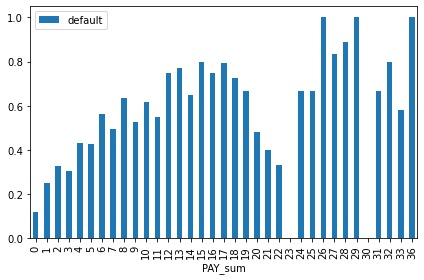

In [167]:
df['PAY_sum'] = np.sum(df.iloc[:, 5:11], axis = 1)
z = df[['PAY_sum', "default"]].groupby(['PAY_sum']).mean().sort_values(by = 'default')
z.sort_index(axis = 0).plot(kind = 'bar')
plt.tight_layout()

Now, to see the correlations between these new features and the output of the final predictive model i.e. default, let us plot again the pair-wise correlations between the features.

In [168]:
df_corr=df[['Bill_credit_ratio1', 'Bill_credit_ratio2', 'Bill_credit_ratio3', 'Bill_credit_ratio4', 'Bill_credit_ratio5', 
            'Bill_credit_ratio6', 'AvgExp_credit_ratio1', 'AvgExp_credit_ratio2', 'AvgExp_credit_ratio3', 
            'AvgExp_credit_ratio4', 'AvgExp_credit_ratio5','Gen','SexMa','SexEd','SexGen','Client1','Client2','Client3','Client4','Client5','Client6','Bill_stab_short','Bill_stab_long',
            'PAY_RAT1', 'PAY_RAT2', 'PAY_RAT3', 'PAY_RAT4', 'PAY_RAT5', 'PAY_RAT6', 'PAY_RAT_VAR1', 'PAY_sum', 'default']]

<AxesSubplot:>

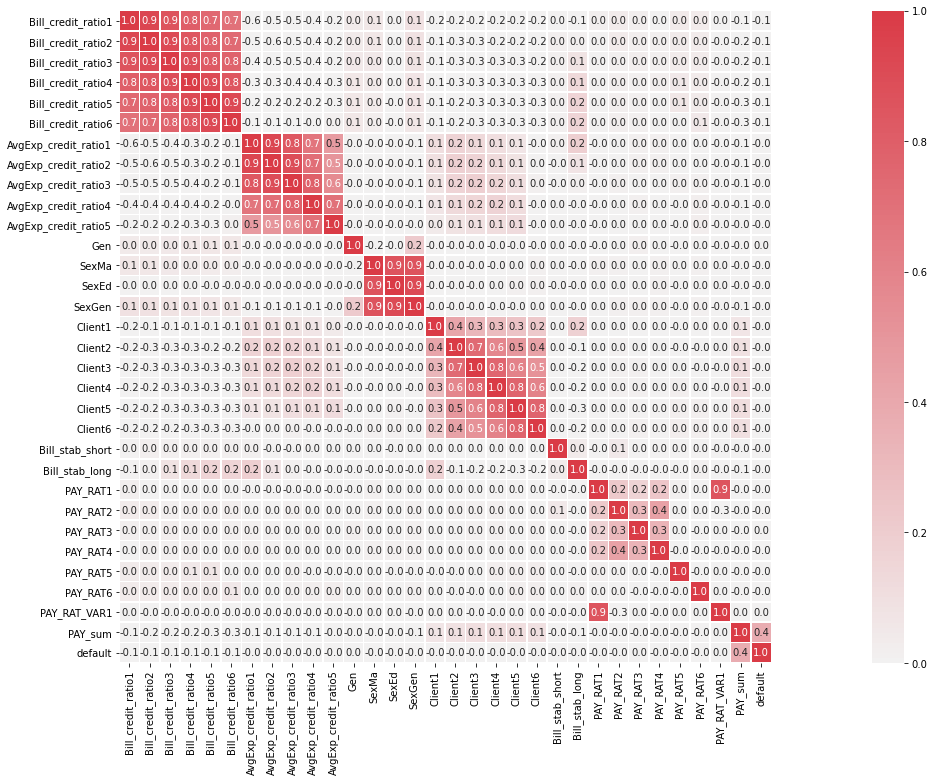

In [169]:
corr2 = df_corr.corr()
plt.subplots(figsize=(36, 12))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(corr2, cmap=cmap, vmin=0, vmax=1, center=0,
    square=True, linewidths=0.5,  annot=True, fmt=".1f" )

Prior to modelling training & validation we shall notice that, as seen in the data visualisation section, our data has imbalanced classes and this is an issue since most learning algorithms are not adapted to a strong imbalance in the representation classes of the dataset. To tackle this issue, different methods exist. Note that these imbalance will be sorted in the training data set only as we aim to optimise the performance of the models so as to capture these imbalances for its posterior implementation in the test data set. Thus, let us separate the data, also setting aside a validation set(20% of the training data) for model performance comparison.

In [170]:
from sklearn.model_selection import train_test_split
training = df.loc['train', :]
train,val = train_test_split(training, test_size = 0.20, random_state = 42, shuffle = True)
test = df.loc['test', :]

To tackle imbalance and, as suggested in ['Prediction of default credit cards users using Data Mining techniques' by Akanksha Shankar Shetty and Manoj R] and ['Credit card fraud detection using machine learning with integration of contextual knowledge' by Yvan Lucas], undersample, oversample and SMOTE will be considered. Thus, the following training data sets will be obtained:
- Given training data set (no changes)
- Rebalanced training dataset using undersampling (downsampling the majority class in order to match the size of the minority class)
- Rebalanced training dataset using oversampling (upsampling the minority class)
- Rebalanced training dataset using SMOTE (creating a synthetic sample in the neighbourhood of the minority class)

In [171]:
X_val = val.drop(['default'], axis=1).copy()#Creating x,y data from the validation set
y_val = val['default'].copy()
X_test = test.drop(['default'], axis=1).copy()#Creating x,y data from the test set
y_test = test['default'].copy()

In [172]:
X_train_given = train.drop(['default'], axis=1).copy()#Creating x,y data from the raw/given train set
Y_train_given = train['default'].copy()
df_train = train.copy()

First, let us define the majority and minority,

In [173]:
df_majority = df_train[df_train.default==0]
df_minority = df_train[df_train.default==1]

Now, let us import the resample function to successfully rebalance the training dataset using undersampling and oversampling and let us proceed doing these,

In [174]:
from sklearn.utils import resample
#undersampling
df_undersampling = resample(df_majority, replace = False, n_samples = df_minority.default.count(), random_state = 42)

Now, let us combine it with the majority class and show that it worked.

In [175]:
df_balanced_undersampling = pd.concat([df_undersampling, df_minority])
print(df_minority.default.value_counts())
print(df_undersampling.default.value_counts())

1    4291
Name: default, dtype: int64
0    4291
Name: default, dtype: int64


In [176]:
X_train_undersampling = df_balanced_undersampling.drop(['default'], axis= 1)
Y_train_undersampling = df_balanced_undersampling.default

Note that the main issue with undersampling is that, when the imbalance is too pronounced, too many examples from the majority class need to be taken away and this may cause a decrease in the performance of the algorithm due to a lack of data. Also, undersampling is usually an interesing choice in unbalanced sets as it speeds up the learning phase.

Similarly, with oversampling,

In [177]:
#oversampling
df_oversampling = resample(df_minority, replace = True, n_samples = df_majority.default.count(), random_state = 42)

Again, combining it with the majority class to show that it worked.

In [178]:
df_balanced_oversampling = pd.concat([df_majority, df_oversampling])
print(df_majority.default.value_counts())
print(df_oversampling.default.value_counts())

0    14892
Name: default, dtype: int64
1    14892
Name: default, dtype: int64


In [179]:
X_train_oversampling = df_balanced_oversampling.drop(['default'], axis= 1)
Y_train_oversampling = df_balanced_oversampling.default

Note that the main issue of oversampling is that repeating some examples does not add information and may lead to an overfitting of the learning algorithms.

Finally, as stated above, let us create a syntetic sample in the neighbourhood of the minority class using SMOTE. 

In [180]:
from imblearn.over_sampling import SMOTE

In [181]:
df_SMOTE = SMOTE(random_state = 42)
X_train_SMOTE, Y_train_SMOTE = df_SMOTE.fit_sample(X_train_given, Y_train_given)

Therefore, as we aimed, the following training data sets are obtained:
- Given training data set (given by X_train_given and Y_train_given)
- Rebalanced training dataset using undersampling (given by X_train_undersampling and Y_train_undersampling)
- Rebalanced training dataset using oversampling (given by X_train_oversampling and Y_train_oversampling)
- Rebalanced training dataset using SMOTE (given by X_train_SMOTE and Y_train_SMOTE)

## Model Training & Validation

First, let us scale all the data sets relative to the training data sets. Due to many of the features being non-gaussian, Min-max scaling was chosen as an alternative.

In [182]:
scaler = MinMaxScaler()
#Fitting scaler to given training data and applying it to all feature data sets
X_train_given = scaler.fit_transform(X_train_given)
X_val_given = scaler.transform(X_val)
X_test_given = scaler.transform(X_test)
#Fitting scaler to undersampled training data and applying it to all feature data sets
X_train_undersampling = scaler.fit_transform(X_train_undersampling)
X_val_undersampling = scaler.transform(X_val)
X_test_undersampling = scaler.transform(X_test)
#Fitting scaler to oversampled training data and applying it to all feature data sets
X_train_oversampling = scaler.fit_transform(X_train_oversampling)
X_val_oversampling = scaler.transform(X_val)
X_test_oversampling = scaler.transform(X_test)
#Fitting scaler to SMOTE training data and applying it to all feature data sets
X_train_SMOTE = scaler.fit_transform(X_train_SMOTE)
X_val_SMOTE = scaler.transform(X_val)
X_test_SMOTE = scaler.transform(X_test)

In [183]:
#Defining functions to make model comparison easier.
def get_results(y_true, y_pred): 
    roc=roc_auc_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary', labels=np.unique(y_pred))
    rec = recall_score(y_true, y_pred, average='binary', labels=np.unique(y_pred))
    f1 = f1_score(y_true, y_pred, average='binary', labels=np.unique(y_pred))
    model_results = pd.DataFrame([[acc,prec,rec, f1,roc]],
                   columns = ['Balanced Accuracy', 'Precision', 
                              'Recall', 'F1 Score','ROC'])    
    return model_results

def make_confusion_matrix(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot = True, square = True, fmt = "d", cmap = 'RdPu', vmin = 0, vmax = 20000)
    plt.title("Confusion Matrix", fontsize = 15) 
    plt.xlabel('predicted')
    plt.ylabel('target')
    return ax
#Setting cross-validation scorer to be the F1 score
scorer=make_scorer(f1_score)

### KNN Model

In [184]:
#KNN hyperparemter tuning for raw/given training data
hyperparametersgiven={'n_neighbors':[1,3,5,7,9,int(len(Y_train_given)**0.5)],'p':[1,2]}#Defining hyperparameter grid for GridSearch
knngridgiven = GridSearchCV(KNeighborsClassifier(), hyperparametersgiven,n_jobs=-1, scoring = scorer, cv = 5)
knngridgiven = knngridgiven.fit(X_train_given,Y_train_given)#Fitting KNN with optimal hyperparemters
knngridgivenresults=pd.concat([pd.DataFrame(knngridgiven.cv_results_["params"]),pd.DataFrame(knngridgiven.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
display(knngridgivenresults)#Displaying GridSearch results
print('Best p:', knngridgiven.best_estimator_.get_params()['p'])#Displaying optimal hyperparameters
print('Best n_neighbors:', knngridgiven.best_estimator_.get_params()['n_neighbors'])
print('Best test score', knngridgiven.best_score_)

n_neighbors  p     Score
0             1  1  0.374070
1             1  2  0.374939
2             3  1  0.387005
3             3  2  0.400301
4             5  1  0.387579
5             5  2  0.407976
6             7  1  0.379418
7             7  2  0.397950
8             9  1  0.380872
9             9  2  0.390433
10          138  1  0.299233
11          138  2  0.309021

Best p: 2
Best n_neighbors: 5
Best test score 0.40797564392325986


In [185]:
hyperparametersundersampling={'n_neighbors':[1,3,5,7,9,int(len(Y_train_undersampling)**0.5)],'p':[1,2]}
knngridundersampling = GridSearchCV(KNeighborsClassifier(), hyperparametersundersampling,n_jobs=-1, scoring = scorer, cv = 5)
knngridundersampling = knngridundersampling.fit(X_train_undersampling,Y_train_undersampling)
knngridundersamplingresults=pd.concat([pd.DataFrame(knngridundersampling.cv_results_["params"]),pd.DataFrame(knngridundersampling.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
display(knngridundersamplingresults)
print('Best p:', knngridundersampling.best_estimator_.get_params()['p'])
print('Best n_neighbors:', knngridundersampling.best_estimator_.get_params()['n_neighbors'])
print('Best test score', knngridundersampling.best_score_)

n_neighbors  p     Score
0             1  1  0.602271
1             1  2  0.602166
2             3  1  0.632195
3             3  2  0.631463
4             5  1  0.639750
5             5  2  0.634182
6             7  1  0.639389
7             7  2  0.636492
8             9  1  0.638238
9             9  2  0.631126
10           92  1  0.615129
11           92  2  0.595739

Best p: 1
Best n_neighbors: 5
Best test score 0.639750316307703


In [186]:
hyperparametersoversampling={'n_neighbors':[1,3,5,7,9,int(len(Y_train_oversampling)**0.5)],'p':[1,2]}
knngridoversampling = GridSearchCV(KNeighborsClassifier(), hyperparametersoversampling,n_jobs=-1, scoring = scorer, cv = 5)
knngridoversampling = knngridoversampling.fit(X_train_oversampling,Y_train_oversampling)
knngridoversamplingresults=pd.concat([pd.DataFrame(knngridoversampling.cv_results_["params"]),pd.DataFrame(knngridoversampling.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
display(knngridoversamplingresults)
print('Best p:', knngridoversampling.best_estimator_.get_params()['p'])
print('Best n_neighbors:', knngridoversampling.best_estimator_.get_params()['n_neighbors'])
print('Best test score', knngridoversampling.best_score_)

n_neighbors  p     Score
0             1  1  0.890881
1             1  2  0.892483
2             3  1  0.819777
3             3  2  0.821388
4             5  1  0.779004
5             5  2  0.780379
6             7  1  0.752660
7             7  2  0.756235
8             9  1  0.740567
9             9  2  0.741573
10          172  1  0.624090
11          172  2  0.608921

Best p: 2
Best n_neighbors: 1
Best test score 0.8924833738889797


In [187]:
hyperparametersSMOTE={'n_neighbors':[1,3,5,7,9,int(len(Y_train_SMOTE)**0.5)],'p':[1,2]}
knngridSMOTE = GridSearchCV(KNeighborsClassifier(), hyperparametersSMOTE,n_jobs=-1, scoring = scorer, cv = 5)
knngridSMOTE = knngridSMOTE.fit(X_train_SMOTE,Y_train_SMOTE.values.ravel())
knngridSMOTEresults=pd.concat([pd.DataFrame(knngridSMOTE.cv_results_["params"]),pd.DataFrame(knngridSMOTE.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
display(knngridSMOTEresults)
print('Best p:', knngridSMOTE.best_estimator_.get_params()['p'])
print('Best n_neighbors:', knngridSMOTE.best_estimator_.get_params()['n_neighbors'])
print('Best test score', knngridSMOTE.best_score_)

n_neighbors  p     Score
0             1  1  0.818734
1             1  2  0.804767
2             3  1  0.797862
3             3  2  0.786754
4             5  1  0.785227
5             5  2  0.777888
6             7  1  0.779510
7             7  2  0.774875
8             9  1  0.774285
9             9  2  0.773542
10          172  1  0.713896
11          172  2  0.718855

Best p: 1
Best n_neighbors: 1
Best test score 0.8187337490478527


With the tuned KNN models obtained, they are validated upon the validation data and various performance metrics calculated, with the best of the four being compared against the other models.

In [188]:
knngiven_ypred_val=knngridgiven.predict(X_val_given)
display(get_results(y_val, knngiven_ypred_val))

knnundersampling_ypred_val=knngridundersampling.predict(X_val_undersampling)
display(get_results(y_val, knnundersampling_ypred_val))

knnoversampling_ypred_val=knngridoversampling.predict(X_val_oversampling)
display(get_results(y_val, knnoversampling_ypred_val))

knnSMOTE_ypred_val=knngridSMOTE.predict(X_val_SMOTE)
display(get_results(y_val, knnSMOTE_ypred_val))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.795038   0.574919  0.328372  0.417999  0.629115

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.669308   0.356702  0.591628  0.445066  0.641689

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.737698   0.406346  0.369302   0.38694  0.606715

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.723937   0.383099  0.379535  0.381308  0.601485

### Decision Trees

For the training data set specified,

In [189]:
dt_given = DecisionTreeClassifier(max_depth = 3, criterion='gini', class_weight='balanced', random_state = 42, max_leaf_nodes = 3)
dt_given.fit(X_train_given, Y_train_given)
dt_given_pred = dt_given.predict(X_train_given)
display(get_results(Y_train_given, dt_given_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.724183   0.424127  0.651363   0.51374  0.698264

Making use of GridSearchCV to determine the ideal combination of parameters,

In [190]:
dt_param_grid = {'max_depth': np.arange(3, 10), 'criterion' : ['gini','entropy'], 'class_weight' : ['balanced'],
             'max_leaf_nodes': [3, 10, 20, 80], 'min_samples_split': [2, 5, 10, 20]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), dt_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_tree = grid_tree.fit(X_train_given, Y_train_given) 
dt_bs = grid_tree.best_score_
dt_given = grid_tree.best_estimator_
dt_given.fit(X_train_given, Y_train_given)
dt_given_pred = dt_given.predict(X_train_given)
display(get_results(Y_train_given, dt_given_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.784809   0.517799  0.552552  0.534611  0.702142

Now, predicting the validation set,

In [191]:
dt_val_pred_given = dt_given.predict(X_val_given)
dt_val_pred_given_score = dt_given.predict_proba(X_val_given)[:,-1]
display(get_results(y_val, dt_val_pred_given))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.792118   0.535649  0.545116  0.540341  0.704297

In [192]:
from sklearn.tree import export_graphviz

In [193]:
export_graphviz(dt_given, 
                out_file='tree.ps2', 
                feature_names = X_val.columns,
                class_names = X_val.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [194]:
!dot -Tpdf tree.dot -o tree_graph1.pdf

'dot' is not recognized as an internal or external command,
operable program or batch file.


For the rebalanced training dataset using undersampling,

In [195]:
dt_undersampling = DecisionTreeClassifier(max_depth = 3, criterion='gini', random_state = 42, max_leaf_nodes = 3)
dt_undersampling.fit(X_train_undersampling, Y_train_undersampling)
dt_undersampling_pred = dt_undersampling.predict(X_train_undersampling)
display(get_results(Y_train_undersampling, dt_undersampling_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.700419   0.722222  0.651363  0.684965  0.700419

Making use of GridSearchCV to determine the ideal combination of parameters,

In [196]:
dt_param_grid = {'max_depth': np.arange(3, 10), 'criterion' : ['gini','entropy'], 'max_leaf_nodes': [3, 10, 20, 100],
             'min_samples_split': [2, 5, 10, 20]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), dt_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_tree = grid_tree.fit(X_train_undersampling, Y_train_undersampling) 
dt_bs = grid_tree.best_score_
dt_undersampling = grid_tree.best_estimator_
dt_undersampling.fit(X_train_undersampling, Y_train_undersampling)
dt_undersampling_pred = dt_undersampling.predict(X_train_undersampling)
display(get_results(Y_train_undersampling, dt_undersampling_pred))

Balanced Accuracy  Precision    Recall  F1 Score      ROC
0            0.72151   0.727556  0.708227  0.717761  0.72151

Now, predicting the validation set,

In [197]:
dt_val_pred_undersampling = dt_undersampling.predict(X_val_undersampling)
display(get_results(y_val, dt_val_pred_undersampling))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.700375    0.40033  0.676279   0.50294  0.691808

For the rebalanced training dataset using oversampling,

In [198]:
dt_oversampling = DecisionTreeClassifier(max_depth = 3, criterion='gini', random_state = 42, max_leaf_nodes = 3)
dt_oversampling.fit(X_train_oversampling, Y_train_oversampling)
dt_oversampling_pred = dt_oversampling.predict(X_train_oversampling)
display(get_results(Y_train_oversampling, dt_oversampling_pred))

Balanced Accuracy  Precision   Recall  F1 Score       ROC
0           0.696918   0.717949  0.64867  0.681554  0.696918

Making use of GridSearchCV to determine the ideal combination of parameters,

In [199]:
dt_param_grid = {'max_depth': np.arange(3, 10), 'criterion' : ['gini','entropy'], 'max_leaf_nodes': [3, 10, 20, 100],
             'min_samples_split': [2, 5, 10, 20]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), dt_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_tree = grid_tree.fit(X_train_oversampling, Y_train_oversampling) 
dt_bs = grid_tree.best_score_
dt_oversampling = grid_tree.best_estimator_
dt_oversampling.fit(X_train_oversampling, Y_train_oversampling)
dt_oversampling_pred = dt_oversampling.predict(X_train_oversampling)
display(get_results(Y_train_oversampling, dt_oversampling_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.749765    0.74621  0.756984  0.751558  0.749765

Now, predicting the validation set,

In [200]:
dt_val_pred_oversampling = dt_oversampling.predict(X_val_oversampling)
display(get_results(y_val, dt_val_pred_oversampling))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.715179   0.414361  0.654884   0.50757  0.693741

For the rebalanced training dataset using SMOTE,

In [201]:
dt_SMOTE = DecisionTreeClassifier(max_depth = 3, criterion='gini', random_state = 42, max_leaf_nodes = 3)
dt_SMOTE.fit(X_train_SMOTE, Y_train_SMOTE)
dt_SMOTE_pred = dt_SMOTE.predict(X_train_SMOTE)
display(get_results(Y_train_SMOTE, dt_SMOTE_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.713437   0.727898  0.681708  0.704047  0.713437

Making use of GridSearchCV to determine the ideal combination of parameters,

In [202]:
dt_param_grid = {'max_depth': np.arange(3, 10), 'criterion' : ['gini','entropy'], 'max_leaf_nodes': [3, 10, 20, 100],
             'min_samples_split': [2, 5, 10, 20]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), dt_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_tree = grid_tree.fit(X_train_SMOTE, Y_train_SMOTE) 
dt_bs = grid_tree.best_score_
dt_SMOTE = grid_tree.best_estimator_
dt_SMOTE.fit(X_train_SMOTE, Y_train_SMOTE)
dt_SMOTE_pred = dt_SMOTE.predict(X_train_SMOTE)
display(get_results(Y_train_SMOTE, dt_SMOTE_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.816176   0.832827  0.791163   0.81146  0.816176

Now, predicting the validation set,

In [203]:
dt_val_pred_SMOTE = dt_SMOTE.predict(X_val_SMOTE)
display(get_results(y_val, dt_val_pred_SMOTE))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.778982   0.506471  0.546047  0.525515  0.696162

### Random Forests

In this type of algorthm, generally more trees will provide a better model. However, the increased computational costs limits the number of trees since the error rate will not decrease significantly after a certain number of trees. Moreover, deep trees are preferred so as to convey information by splitting each node.

For the given training data set,

In [204]:
rf_given = RandomForestClassifier(n_estimators = 100, class_weight='balanced', criterion='gini', random_state = 42)
rf_given.fit(X_train_given, Y_train_given)
rf_given_pred = rf_given.predict(X_train_given)
display(get_results(Y_train_given, rf_given_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.999427   0.997906  0.999534  0.998719  0.999465

Making use of GridSearchCV to determine the ideal combination of parameters,

In [205]:
rf_param_grid = {'n_estimators' : [100, 300, 500, 1000], 'criterion' : ['entropy', 'gini'], 
            'random_state' : [42], 'n_jobs' : [-1], 'class_weight' : ['balanced']}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_rf = grid_rf.fit(X_train_given, Y_train_given) 
rf_bs = grid_rf.best_score_
rf_given = grid_rf.best_estimator_
rf_given.fit(X_train_given, Y_train_given)
rf_given_pred = rf_given.predict(X_train_given)
display(get_results(Y_train_given, rf_given_pred))

Balanced Accuracy  Precision  Recall  F1 Score       ROC
0           0.999531   0.997907     1.0  0.998952  0.999698

Now, predicting the validation set,

In [206]:
rf_val_pred_given = rf_given.predict(X_val_given)
display(get_results(y_val, rf_val_pred_given))

Balanced Accuracy  Precision    Recall  F1 Score      ROC
0           0.822352   0.705341  0.356279  0.473424  0.65664

For the rebalanced training dataset using undersampling,

In [207]:
rf_undersampling = RandomForestClassifier(n_estimators = 100, criterion='gini', random_state = 42)
rf_undersampling.fit(X_train_undersampling, Y_train_undersampling)
rf_undersampling_pred = rf_undersampling.predict(X_train_undersampling)
display(get_results(Y_train_undersampling, rf_undersampling_pred))

Balanced Accuracy  Precision  Recall  F1 Score      ROC
0            0.99965   0.999301     1.0  0.999651  0.99965

Making use of GridSearchCV to determine the ideal combination of parameters,

In [208]:
rf_param_grid = {'n_estimators' : [100, 300, 500, 1000], 'criterion' : ['entropy', 'gini'], 'random_state' : [42],
            'n_jobs' : [-1]}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_rf = grid_rf.fit(X_train_undersampling, Y_train_undersampling) 
rf_bs = grid_rf.best_score_
rf_undersampling = grid_rf.best_estimator_
rf_undersampling.fit(X_train_undersampling, Y_train_undersampling)
rf_undersampling_pred = rf_undersampling.predict(X_train_undersampling)
display(get_results(Y_train_undersampling, rf_undersampling_pred))

Balanced Accuracy  Precision  Recall  F1 Score      ROC
0            0.99965   0.999301     1.0  0.999651  0.99965

Now, predicting the validation set,

In [209]:
rf_val_pred_undersampling = rf_undersampling.predict(X_val_undersampling)
display(get_results(y_val, rf_val_pred_undersampling))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.743119   0.448592  0.637209  0.526518  0.705463

For the rebalanced training dataset using oversampling,

In [210]:
rf_oversampling = RandomForestClassifier(n_estimators = 100, criterion='gini', random_state = 42)
rf_oversampling.fit(X_train_oversampling, Y_train_oversampling)
rf_oversampling_pred = rf_oversampling.predict(X_train_oversampling)
display(get_results(Y_train_oversampling, rf_oversampling_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.999698    0.99953  0.999866  0.999698  0.999698

Making use of GridSearchCV to determine the ideal combination of parameters,

In [211]:
rf_param_grid = {'n_estimators' : [100, 300, 500, 1000], 'criterion' : ['entropy', 'gini'], 'random_state' : [42],
            'n_jobs' : [-1]}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_rf = grid_rf.fit(X_train_oversampling, Y_train_oversampling)
rf_bs = grid_rf.best_score_
rf_oversampling = grid_rf.best_estimator_
rf_oversampling.fit(X_train_oversampling, Y_train_oversampling)
rf_oversampling_pred = rf_oversampling.predict(X_train_oversampling)
display(get_results(Y_train_oversampling, rf_oversampling_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.999698    0.99953  0.999866  0.999698  0.999698

Now, predicting the validation set,

In [212]:
rf_val_pred_oversampling = rf_oversampling.predict(X_val_oversampling)
display(get_results(y_val, rf_val_pred_oversampling))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0            0.81422   0.627072  0.422326  0.504725  0.674882

For the rebalanced training dataset using SMOTE,

In [213]:
rf_SMOTE = RandomForestClassifier(n_estimators = 100, criterion='gini', random_state = 42)
rf_SMOTE.fit(X_train_SMOTE, Y_train_SMOTE)
rf_SMOTE_pred = rf_SMOTE.predict(X_train_SMOTE)
display(get_results(Y_train_SMOTE, rf_SMOTE_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.999631   0.999597  0.999664  0.999631  0.999631

Making use of GridSearchCV to determine the ideal combination of parameters,

In [214]:
rf_param_grid = {'n_estimators' : [100, 300, 500, 1000], 'criterion' : ['entropy', 'gini'], 'random_state' : [42],
            'n_jobs' : [-1]}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_rf = grid_rf.fit(X_train_SMOTE, Y_train_SMOTE) 
rf_bs = grid_rf.best_score_
rf_SMOTE = grid_rf.best_estimator_
rf_SMOTE.fit(X_train_SMOTE, Y_train_SMOTE)
rf_SMOTE_pred = rf_SMOTE.predict(X_train_SMOTE)
display(get_results(Y_train_SMOTE, rf_SMOTE_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.999631   0.999597  0.999664  0.999631  0.999631

Now, predicting the validation set,

In [215]:
rf_val_pred_SMOTE = rf_SMOTE.predict(X_val_SMOTE)
display(get_results(y_val, rf_val_pred_SMOTE))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.811301   0.613032  0.428837  0.504652  0.675316

### Gradient Boost

For each of the sampling techniques, various hyperparameters are tuned, with the optimal pairings being validated upon the validation set.

For given data:

In [216]:
# learning rate 
p_test1 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(n_estimators = 100, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test1, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_given,Y_train_given)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15}, 0.4661154802082222)

In [217]:
# n_estimators
p_test2 = {'n_estimators':[100,250,500,750,1000,1250,1500,1750]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate = 0.05, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test2, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_given,Y_train_given)
tuning.best_params_, tuning.best_score_

({'n_estimators': 1250}, 0.4684040017379793)

In [218]:
#max+depth
p_test3 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=100, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test3, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_given,Y_train_given)
tuning.best_params_, tuning.best_score_

({'max_depth': 7}, 0.459791656919515)

In [219]:
gb = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1)
gb.fit(X_train_given,Y_train_given)

y_pred_given = gb.predict(X_val_given)

In [220]:
get_results(y_val, y_pred_given)

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.823812   0.705357  0.367442   0.48318  0.661549

For undersampling:

In [221]:
# learning rate 
p_test1 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(n_estimators = 100, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test1, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_undersampling,Y_train_undersampling)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.05}, 0.6995429196631073)

In [222]:
# n_estimators
p_test2 = {'n_estimators':[100,250,500,750,1000,1250,1500,1750]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate = 0.05, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test2, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_undersampling,Y_train_undersampling)
tuning.best_params_, tuning.best_score_

({'n_estimators': 100}, 0.6995565956656056)

In [223]:
#max depth
p_test3 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=100, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test3, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_undersampling,Y_train_undersampling)
tuning.best_params_, tuning.best_score_

({'max_depth': 3}, 0.6998042658319787)

In [224]:
gb_undersampling = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1)
gb_undersampling.fit(X_train_undersampling,Y_train_undersampling)

gb_val_pred_undersampling = gb_undersampling.predict(X_val_undersampling)

In [225]:
get_results(y_val, gb_val_pred_undersampling)

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.738949    0.44381  0.650233  0.527547  0.707406

In [226]:
gb_val_pred_undersampling_score = gb_undersampling.predict_proba(X_val_undersampling)[:,-1]

For oversamping data:

In [227]:
# learning rate 
p_test1 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(n_estimators = 100, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test1, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_oversampling,Y_train_oversampling)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15}, 0.7558556514513622)

In [228]:
# n_estimators
p_test2 = {'n_estimators':[100,250,500,750,1000,1250,1500,1750]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate = 0.001, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test2, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_oversampling,Y_train_oversampling)
tuning.best_params_, tuning.best_score_

({'n_estimators': 1750}, 0.694639015283727)

In [229]:
#max depth
p_test3 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.001,n_estimators=100, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test3, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_oversampling,Y_train_oversampling)
tuning.best_params_, tuning.best_score_

({'max_depth': 7}, 0.7179932257662307)

In [230]:
gb = ensemble.GradientBoostingClassifier(learning_rate=0.001, n_estimators=100,max_depth=2, min_samples_split=2, min_samples_leaf=1, subsample=1)
gb.fit(X_train_oversampling,Y_train_oversampling)

y_pred_oversampling = gb.predict(X_val_oversampling)

In [231]:
get_results(y_val, y_pred_oversampling)

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.732902   0.435625  0.648372  0.521121  0.702848

For SMOTE:

In [232]:
# learning rate 
p_test1 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(n_estimators = 100, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test1, scoring=scorer,n_jobs=-1, cv=2)
tuning.fit(X_train_SMOTE,Y_train_SMOTE)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15}, 0.752742087519618)

In [233]:
# n_estimators
p_test2 = {'n_estimators':[100,250,500,750,1000,1250,1500,1750]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate = 0.15, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test2, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_SMOTE,Y_train_SMOTE)
tuning.best_params_, tuning.best_score_

({'n_estimators': 1250}, 0.7997614722079088)

In [234]:
#max depth
p_test3 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.15,n_estimators=100, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test3, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_SMOTE,Y_train_SMOTE)
tuning.best_params_, tuning.best_score_

({'max_depth': 7}, 0.8063797884220459)

In [235]:
gb = ensemble.GradientBoostingClassifier(learning_rate=0.15, n_estimators=100,max_depth=2, min_samples_split=2, min_samples_leaf=1, subsample=1)
gb.fit(X_train_SMOTE,Y_train_SMOTE)

y_pred_SMOTE = gb.predict(X_val_SMOTE)

In [236]:
get_results(y_val, y_pred_SMOTE)#validation dataset

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.815471   0.627346  0.435349  0.514003  0.680319

### Adaboost

For each of the sampling techniques, various hyperparameters are tuned, with the optimal pairings being validated upon the validation set.

For given dataset:

In [237]:
# learning rate 
p_test1 = {'learning_rate':[2,1.5,1,0.5,0.1,0.05,0.01]}
tuning = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = p_test1, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_given,Y_train_given)
tuning.best_params_, tuning.best_score_

({'learning_rate': 1}, 0.44956493452614615)

In [238]:
# n_estimators
p_test2 = {'n_estimators':[10, 50,100,250,500,750,1000,1250]}
tuning = GridSearchCV(estimator =AdaBoostClassifier(learning_rate = 1.5), 
            param_grid = p_test2, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_given,Y_train_given)
tuning.best_params_, tuning.best_score_

({'n_estimators': 50}, 0.4460235431328655)

In [239]:
# training and predicting
ada = ensemble.AdaBoostClassifier(n_estimators = 50, learning_rate = 1.5)
ada.fit(X_train_given,Y_train_given)

y_pred_given = ada.predict(X_val_given)

In [240]:
get_results(y_val, y_pred_given)#validation dataset

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.817765   0.681736  0.350698  0.463145  0.651699

For undersampling data:

In [241]:
# learning rate 
p_test1 = {'learning_rate':[2,1.5,1,0.5,0.1,0.05,0.01]}
tuning = GridSearchCV(estimator =AdaBoostClassifier(), 
            param_grid = p_test1, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_undersampling,Y_train_undersampling)
tuning.best_params_, tuning.best_score_

({'learning_rate': 1}, 0.6939373169644357)

In [242]:
# n_estimators
p_test2 = {'n_estimators':[10, 50,100,250,500,750,1000,1250]}
tuning = GridSearchCV(estimator =AdaBoostClassifier(learning_rate=1), 
            param_grid = p_test2, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_undersampling,Y_train_undersampling)
tuning.best_params_, tuning.best_score_

({'n_estimators': 100}, 0.6972034694595308)

In [243]:
# training and predicting
ada = ensemble.AdaBoostClassifier(n_estimators = 100, learning_rate = 1)
ada.fit(X_train_undersampling,Y_train_undersampling)

y_pred_undersampling = ada.predict(X_val_undersampling)

In [244]:
get_results(y_val,y_pred_undersampling)#validation dataset

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.736239   0.440327  0.652093  0.525684  0.706321

For oversampling data:

In [245]:
# learning rate 
p_test1 = {'learning_rate':[2,1.5,1,0.5,0.1,0.05,0.01]}
tuning = GridSearchCV(estimator =AdaBoostClassifier(), 
            param_grid = p_test1, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_oversampling,Y_train_oversampling)
tuning.best_params_, tuning.best_score_

({'learning_rate': 1}, 0.6959324579160449)

In [246]:
# n_estimators
p_test2 = {'n_estimators':[10, 50,100,250,500,750,1000,1250]}
tuning = GridSearchCV(estimator =AdaBoostClassifier(learning_rate=2), 
            param_grid = p_test2, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_oversampling,Y_train_oversampling)
tuning.best_params_, tuning.best_score_

({'n_estimators': 10}, 0.6102285143541183)

In [247]:
# training and predicting
ada = ensemble.AdaBoostClassifier(n_estimators = 10, learning_rate = 2)
ada.fit(X_train_oversampling,Y_train_oversampling)

y_pred_oversampling = ada.predict(X_val_oversampling)

In [248]:
get_results(y_val,y_pred_oversampling)#validation dataset

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.732902   0.435625  0.648372  0.521121  0.702848

For SMOTE:

In [249]:
# learning rate 
p_test1 = {'learning_rate':[2,1.5,1,0.5,0.1,0.05,0.01]}
tuning = GridSearchCV(estimator =AdaBoostClassifier(), 
            param_grid = p_test1, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_SMOTE,Y_train_SMOTE)
tuning.best_params_, tuning.best_score_

({'learning_rate': 1.5}, 0.7860848654466361)

In [250]:
# n_estimators
p_test2 = {'n_estimators':[10, 50,100,250,500,750,1000,1250]}
tuning = GridSearchCV(estimator =AdaBoostClassifier(learning_rate = 2), 
            param_grid = p_test2, scoring=scorer,n_jobs=-1, cv=5)
tuning.fit(X_train_SMOTE,Y_train_SMOTE)
tuning.best_params_, tuning.best_score_

({'n_estimators': 1250}, 0.20102171136653896)

In [251]:
# training and predicting
ada = ensemble.AdaBoostClassifier(n_estimators = 10, learning_rate = 2)
ada.fit(X_train_SMOTE,Y_train_SMOTE)

y_pred_SMOTE = ada.predict(X_val_SMOTE)

In [252]:
get_results(y_val, y_pred_SMOTE)#validation dataset

Balanced Accuracy  Precision  Recall  F1 Score  ROC
0           0.224145   0.224145     1.0  0.366207  0.5

### Support Vector Machine Model

Due to SVM's extensive training time, before hyperparameter tuning, the default model was trained upon each training set (to preemptively spot any problems).

In [253]:
svm_given = svm.SVC(kernel='rbf')
svm_given.fit(X_train_given, Y_train_given)
svm_given_pred = svm_given.predict(X_train_given)
display(get_results(Y_train_given, svm_given_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.815253   0.660369  0.358425  0.464653  0.652654

Making use of GridSearchCV to determine the ideal combination of parameters,

In [254]:
svm_param_grid = {'C' : [1, 10, 100, 1000, 10000], 'gamma' : [1,0.1, 0.01, 0.001, 0.0001], 'kernel' : ['rbf']
    
}
grid_sv = GridSearchCV(SVC(), svm_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_sv = grid_sv.fit(X_train_given, Y_train_given) 
svm_bs = grid_sv.best_score_
svm_given = grid_sv.best_estimator_
svm_given.fit(X_train_given, Y_train_given)
svm_given_pred = svm_given.predict(X_train_given)
display(get_results(Y_train_given, svm_given_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.816087   0.651569  0.382195  0.481786  0.661652

predicting the validation set,

In [255]:
svm_val_pred = svm_given.predict(X_val_given)
display(get_results(y_val, svm_val_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.823812   0.689769  0.388837  0.497323  0.669157

Undersampling

In [256]:
svm_undersampling = svm.SVC(kernel='rbf')
svm_undersampling.fit(X_train_undersampling, Y_train_undersampling)
svm_undersampling_pred = svm_undersampling.predict(X_train_undersampling)
display(get_results(Y_train_undersampling, svm_undersampling_pred))

Balanced Accuracy  Precision   Recall  F1 Score       ROC
0           0.698672   0.800282  0.52948  0.637307  0.698672

Use gridCV

In [257]:
svm_param_grid = {'C' : [1, 10, 100, 1000, 10000], 'gamma' : [1,0.1, 0.01, 0.001, 0.0001], 'kernel' : ['rbf']
                 }
grid_sv = GridSearchCV(SVC(), svm_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_sv = grid_sv.fit(X_train_undersampling, Y_train_undersampling) 
svm_bs = grid_sv.best_score_
svm_undersampling = grid_sv.best_estimator_
svm_undersampling.fit(X_train_undersampling, Y_train_undersampling)
svm_undersampling_pred = svm_undersampling.predict(X_train_undersampling)
display(get_results(Y_train_undersampling, svm_undersampling_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.738289   0.795435  0.641575  0.710268  0.738289

predicting the validation set,

In [258]:
svm_val_pred = svm_undersampling.predict(X_val_undersampling)
display(get_results(y_val, svm_val_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.753753   0.461257  0.586977  0.516578  0.694456

Oversampling

In [259]:
svm_oversampling = svm.SVC(kernel='rbf')
svm_oversampling.fit(X_train_oversampling, Y_train_oversampling)
svm_oversampling_pred = svm_oversampling.predict(X_train_oversampling)
display(get_results(Y_train_oversampling, svm_oversampling_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.696481    0.79022  0.534985  0.638024  0.696481

Use GridSearch

In [260]:
svm_param_grid = {'C' : [1, 10, 100, 1000, 10000], 'gamma' : [1,0.1, 0.01, 0.001, 0.0001], 'kernel' : ['rbf']
                 }
grid_sv = GridSearchCV(SVC(), svm_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_sv = grid_sv.fit(X_train_oversampling, Y_train_oversampling) 
svm_bs = grid_sv.best_score_
svm_oversampling = grid_sv.best_estimator_
svm_oversampling.fit(X_train_oversampling, Y_train_oversampling)
svm_oversampling_pred = svm_oversampling.predict(X_train_oversampling)
display(get_results(Y_train_oversampling, svm_oversampling_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.934059   0.945179  0.921569  0.933225  0.934059

predicting the validation set,

In [261]:
svm_val_pred = svm_oversampling.predict(X_val_oversampling)
display(get_results(y_val, svm_val_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.717056   0.379487  0.413023  0.395546  0.608957

SMOTE

In [262]:
svm_SMOTE = svm.SVC(kernel='rbf')
svm_SMOTE.fit(X_train_SMOTE, Y_train_SMOTE)
svm_SMOTE_pred = svm_SMOTE.predict(X_train_SMOTE)
display(get_results(Y_train_SMOTE, svm_SMOTE_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.821246   0.869079  0.756446   0.80886  0.821246

Use GridSearch

In [263]:
svm_param_grid = {'C' : [1, 10, 100, 1000, 10000], 'gamma' : [1,0.1, 0.01, 0.001, 0.0001], 'kernel' : ['rbf']
                 }
grid_sv = GridSearchCV(SVC(), svm_param_grid,n_jobs=-1, scoring = scorer, cv = 5)
grid_sv = grid_sv.fit(X_train_SMOTE, Y_train_SMOTE) 
svm_bs = grid_sv.best_score_
svm_SMOTE = grid_sv.best_estimator_
svm_SMOTE.fit(X_train_SMOTE, Y_train_SMOTE)
svm_SMOTE_pred = svm_SMOTE.predict(X_train_SMOTE)
display(get_results(Y_train_SMOTE, svm_SMOTE_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.903841   0.953818  0.848778  0.898238  0.903841

predicting the validation set,

In [264]:
svm_val_pred = svm_SMOTE.predict(X_val_SMOTE)
display(get_results(y_val, svm_val_pred))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.788574   0.541838  0.367442  0.437916  0.638841

### Logistic Regression

Due to Logistic Regressions relative simplicitly, a function that tunes the hyperparemeters and outputs the best model was able to be created.

In [265]:
#logistic Regression function

# x1,x2 and y1,y2 are the respective training and validation datasets and z is the label
def logistic_regression(x1,x2,y1,y2,z):
    
    # Set up the hyperparameter grid, with the tuning parameter denoted by C.
    param_grid = {'C': np.logspace(-5, 8, 15)}

    # Instantiate a logistic regression classifier
    logreg = LogisticRegression()

    # Instantiate the GridsearchCV object.
    logreg_cv = GridSearchCV(logreg,param_grid,n_jobs=-1, cv=5)

    # Fit it to the data.
    logreg_cv.fit(x1,y1)

    # Print the tuned parameter, given by logreg_cv.best_params_
    print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

    # Use this tuned parameter to find f1 score for logistic regression
    lr = LogisticRegression(C=logreg_cv.best_params_.get('C'), random_state=0)
    lr.fit(x1,y1)
    Y_pred = lr.predict(x2)

    # Get results for algorithm
    display(get_results(y2, Y_pred))

In [266]:
logistic_regression(X_train_given,X_val_given,Y_train_given,y_val,"Logistic Regression on given data")

Tuned Logistic Regression Parameters: {'C': 19306.977288832535}


Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.819016   0.717895  0.317209      0.44  0.640599

In [267]:
logistic_regression(X_train_undersampling,X_val_undersampling,Y_train_undersampling,y_val,"Logistic Regression on undersampled data")

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}


Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.775229   0.498829  0.594419  0.542445  0.710942

In [268]:
logistic_regression(X_train_oversampling,X_val_oversampling,Y_train_oversampling,y_val,"Logistic Regression on oversampled data")

Tuned Logistic Regression Parameters: {'C': 0.05179474679231213}


Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.780651   0.509267  0.587907  0.545769  0.712121

In [269]:
logistic_regression(X_train_SMOTE,X_val_SMOTE,Y_train_SMOTE,y_val,"Logistic Regression on SMOTE data")

Tuned Logistic Regression Parameters: {'C': 11787686.347935867}


Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.816305   0.670175  0.355349  0.464438  0.652412

### Gaussian Naive Bayes

The same type of function was created for GNB as well.

In [270]:
# Gaussian Naive Bayes function

from sklearn.pipeline import Pipeline

# x1,x2 and y1,y2 are the respective training and validation datasets and z is the label
def gaussian_naive_bayes(x1,x2,y1,y2,z):

    pipeline = Pipeline([
    ('clf', GaussianNB())
    ])

    parameters = {
    'clf__priors': [None],
    'clf__var_smoothing': [0.00000001]
    }

    gnb = GridSearchCV(pipeline, param_grid=parameters,n_jobs=-1,cv=5)

    gnb.fit(x1,y1)
    Y_pred_gnb = gnb.predict(x2)

    # Get results for algorithm
    display(get_results(y2, Y_pred_gnb))

In [271]:
gaussian_naive_bayes(X_train_given,X_val_given,Y_train_given,y_val,"Gaussian Naive Bayes on given data")

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0            0.30588   0.238029  0.952558  0.380882  0.535806

In [272]:
gaussian_naive_bayes(X_train_undersampling,X_val_undersampling,Y_train_undersampling,y_val,"Gaussian Naive Bayes on undersampled data")

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.329858    0.24297  0.940465  0.386173  0.546959

In [273]:
gaussian_naive_bayes(X_train_oversampling,X_val_oversampling,Y_train_oversampling,y_val,"Gaussian Naive Bayes on oversampled data")

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.300876   0.237073  0.955349  0.379878  0.533573

In [274]:
gaussian_naive_bayes(X_train_SMOTE,X_val_SMOTE,Y_train_SMOTE,y_val,"Gaussian Naive Bayes on SMOTE data")

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.313803   0.238926  0.943256  0.381275  0.537605

### Neural Network 

Given / raw data

In [275]:

# Processing of all the Xs and Ys to be fit for PyTorch.
y_train = Y_train_given.to_numpy()
Y_val = y_val.to_numpy()
x_train = X_train_given
x_val = X_val_given
y_train = torch.tensor(y_train.astype('float32')).unsqueeze(1)
x_train = torch.tensor(x_train.astype('float32'))
Y_val = torch.tensor(Y_val.astype('float32')).unsqueeze(1)
x_val = torch.tensor(x_val.astype('float32'))
l0 = len(x_train[0]) # Input layer size

In [276]:
import torch.nn as nn
import torch.nn.functional as F

# define the class of the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # define the actual structure of the NN. All the values except l0 and 1 in the last layer output are for you to choose. We found 
        # that the structure didn't change our results so we used the same structure for all tests
        self.l1 = nn.Linear(l0,14)
        self.l2 = nn.Linear(14,8)
        self.l3 = nn.Linear(8,1) 
    def forward(self,x):
        # Define the forward propagtion. Using ReLu.
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
net = Net() # define the actual NN
print(net) # printing the NN to see its details

Net(
  (l1): Linear(in_features=54, out_features=14, bias=True)
  (l2): Linear(in_features=14, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=1, bias=True)
)


In [277]:


# Define the Evaluation method as mean squared error loss aka L2. Use Stochastic gradient descent as optimizer with 0.001 learning rate
# Using bigger learining rates leads to big jumping once model finds it's optimal point.

import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001)

In [278]:
# pre training functions
# First one gets the overall accuracy, second one gets accuracy for specific label
# avided using any for loops to keep timing not too bad
def acc(x,y,net_t):
    total = 0
    correct = 0
    with torch.no_grad():
        outputs = net_t(x)
        pred = np.round(outputs.numpy()[:])
        s = np.subtract(pred,y)
    per =sum(abs(s))
    per = (per/len(y))*100
    per = 100-per
    return per.numpy()[0]
def acc_val(x,y,net_t,target = 1):
    total = 0
    correct = 0
    with torch.no_grad():
        outputs = net_t(x)
        pred = np.round(outputs.numpy()[:])
        #s = np.subtract(pred,y)
    df = pd.DataFrame()
    df['pred'] = pred[:,0]
    y = y.numpy()
    df['y'] = y
    t = df[df['y']==target]
    pred = len(t[t['pred']==target])
    return pred/len(t)*100 

In [279]:
# Setting up all the hyperparamters and data that i'll need
size = len(x_train)
n_epochs = 400# 400 seems to be a good stop to avoid overfitting to the training values
batch_size = 2**6 # Using mini batches of 64 to speed up trainig and take bigger steps in gradient descent
recall_train = []
selec_train = []
total_train = []
recall_val = []
selec_val = []
total_val = []
l = []
# Enter epoch loop
for epoch in range(n_epochs):

    running_loss = 0
    permutation = torch.randperm(x_train.size()[0])
    # Once batches are set we enter the training loop
    for i in range(0,x_train.size()[0], batch_size):
        optimizer.zero_grad()
        # Setting up the batches for each training itteration
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        # training loop
        outputs = net(batch_x)
        loss = criterion(outputs,batch_y)
        loss.backward()
        optimizer.step()
        # Loop to collect and print the perfomance of the model 
        running_loss += loss.item()
        if i%19008 == 0 and i != 0 and epoch%10 ==0 :   
            t = acc(x_train,y_train,net)
            t0 = acc_val(x_train,y_train,net,0)
            t1 = acc_val(x_train,y_train,net,1)
            v = acc(x_val,Y_val,net)
            v0 = acc_val(x_val,Y_val,net,0)
            v1 = acc_val(x_val,Y_val,net,1)
            recall_train.append(t1)
            selec_train.append(t0)
            total_train.append(t)
            recall_val.append(v1)
            selec_val.append(v0)
            total_val.append(v)
            l.append((running_loss/i)*batch_size)
            print('[%d,%5d] loss: %.3f, Val: %.3f, %.3f, %.3f Train: %.3f, %.3f, %.3f' % 
                  (epoch , i,(running_loss/i)*batch_size,v,v0, v1,t,t0, t1))

print('Finished Training')

[0,19008] loss: 0.174, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[10,19008] loss: 0.173, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[20,19008] loss: 0.172, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[30,19008] loss: 0.171, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[40,19008] loss: 0.171, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[50,19008] loss: 0.169, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[60,19008] loss: 0.168, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[70,19008] loss: 0.166, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[80,19008] loss: 0.164, Val: 77.585, 100.000, 0.000 Train: 77.631, 100.000, 0.000
[90,19008] loss: 0.161, Val: 77.648, 99.893, 0.651 Train: 77.689, 99.933, 0.489
[100,19008] loss: 0.159, Val: 77.898, 99.812, 2.047 Train: 77.751, 99.839, 1.095
[110,19008] loss: 0.155, Val: 78.169, 99.704, 3.628 Train: 77.902, 99.644, 2.447
[120,19008] loss: 0.1

In [280]:
torch.save(net.state_dict(), 'given_lr0.001')  #saving the weights and structure of the model for later use to avoid having to traing again 

In [281]:
# Making a dataframe which will hold the results for trainig and validation data for each epoch
res = pd.DataFrame()
res['recall_train'] = recall_train 
res['selec_train'] = selec_train 
res['total_train'] = total_train 
res['recall_val'] = recall_val
res['selec_val'] = selec_val
res['total_val'] = total_val
res['loss'] = l
res.to_csv('given_lr0.001.csv')

For oversampling,

In [282]:

# Processing of all the Xs and Ys to be fit for PyTorch.
# I also processed the Test values for use in the final stage of the notebook
y_train = Y_train_oversampling.to_numpy()
Y_val = y_val.to_numpy()
Y_test = y_test.to_numpy()
x_train = X_train_oversampling
x_val = X_val_oversampling
x_test = X_test_oversampling
y_train = torch.tensor(y_train.astype('float32')).unsqueeze(1)
x_train = torch.tensor(x_train.astype('float32'))
Y_val = torch.tensor(Y_val.astype('float32')).unsqueeze(1)
x_val = torch.tensor(x_val.astype('float32'))
Y_test = torch.tensor(Y_test.astype('float32')).unsqueeze(1)
x_test = torch.tensor(x_test.astype('float32'))
# define new network
net_over = Net()
optimizer = optim.SGD(net_over.parameters(),lr = 0.001)

In [283]:
size = len(x_train)
n_epochs = 400
batch_size = 2**6 
recall_train = []
selec_train = []
total_train = []
recall_val = []
selec_val = []
total_val = []
l = []
# Enter epoch loop
for epoch in range(n_epochs):

    running_loss = 0
    permutation = torch.randperm(x_train.size()[0])
    # Once batches are set we enter the training loop
    for i in range(0,x_train.size()[0], batch_size):
        optimizer.zero_grad()
        # Setting up the batches for each training itteration
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        # training loop
        outputs = net_over(batch_x)
        loss = criterion(outputs,batch_y)
        loss.backward()
        optimizer.step()
        # Loop to collect and print the perfomance of the model 
        running_loss += loss.item()
        if i%29760 == 0 and i != 0 and epoch%10 ==0 :    
            t = acc(x_train,y_train,net_over)
            t0 = acc_val(x_train,y_train,net_over,0)
            t1 = acc_val(x_train,y_train,net_over,1)
            v = acc(x_val,Y_val,net_over)
            v0 = acc_val(x_val,Y_val,net_over,0)
            v1 = acc_val(x_val,Y_val,net_over,1)
            recall_train.append(t1)
            selec_train.append(t0)
            total_train.append(t)
            recall_val.append(v1)
            selec_val.append(v0)
            total_val.append(v)
            l.append((running_loss/i)*batch_size)
            print('[%d,%5d] loss: %.3f, Val: %.3f, %.3f, %.3f Train: %.3f, %.3f, %.3f ' % 
                  (epoch , i,(running_loss/i)*batch_size,v,v0, v1,t,t0, t1))

print('Finished Training')

[0,29760] loss: 0.254, Val: 77.585, 100.000, 0.000 Train: 50.000, 100.000, 0.000 
[10,29760] loss: 0.251, Val: 41.326, 35.421, 61.767 Train: 49.678, 36.080, 63.276 
[20,29760] loss: 0.250, Val: 48.123, 44.182, 61.767 Train: 52.649, 44.111, 61.187 
[30,29760] loss: 0.248, Val: 69.746, 76.565, 46.140 Train: 60.801, 76.820, 44.782 
[40,29760] loss: 0.246, Val: 68.578, 72.911, 53.581 Train: 63.094, 73.731, 52.458 
[50,29760] loss: 0.241, Val: 72.456, 78.017, 53.209 Train: 64.719, 78.626, 50.813 
[60,29760] loss: 0.234, Val: 75.480, 81.913, 53.209 Train: 66.804, 82.413, 51.195 
[70,29760] loss: 0.224, Val: 77.565, 84.816, 52.465 Train: 68.191, 83.958, 52.424 
[80,29760] loss: 0.214, Val: 77.982, 84.843, 54.233 Train: 68.886, 83.421, 54.351 
[90,29760] loss: 0.208, Val: 77.585, 84.010, 55.349 Train: 69.534, 82.306, 56.762 
[100,29760] loss: 0.205, Val: 77.314, 83.365, 56.372 Train: 69.944, 82.118, 57.769 
[110,29760] loss: 0.203, Val: 77.210, 82.478, 58.977 Train: 70.142, 81.070, 59.213 
[12

In [284]:
torch.save(net.state_dict(), '../over_lr0.001') 
res = pd.DataFrame()
res['recall_train'] = recall_train 
res['selec_train'] = selec_train 
res['total_train'] = total_train 
res['recall_val'] = recall_val
res['selec_val'] = selec_val
res['total_val'] = total_val
#res['recall_test'] = recall_test
#res['selec_test'] = selec_test
#res['total_test'] = total_test
res['loss'] = l
res.to_csv('../over_lr0.001.csv')

In [285]:
# Processing of all the Xs and Ys to be fit for PyTorch.
y_train = Y_train_undersampling.to_numpy()
Y_val = y_val.to_numpy()
x_train = X_train_undersampling#.to_numpy()
x_val = X_val_undersampling#.to_numpy()
y_train = torch.tensor(y_train.astype('float32')).unsqueeze(1)
x_train = torch.tensor(x_train.astype('float32'))
Y_val = torch.tensor(Y_val.astype('float32')).unsqueeze(1)
x_val = torch.tensor(x_val.astype('float32'))
l0 = len(x_train[0]) # Input layer size

For undersampling,

In [286]:
net_under = Net()
optimizer = optim.SGD(net_under.parameters(),lr = 0.001)
size = len(x_train)
n_epochs = 400# 
batch_size = 2**6 
recall_train = []
selec_train = []
total_train = []
recall_val = []
selec_val = []
total_val = []
l = []
# Enter epoch loop
for epoch in range(n_epochs):

    running_loss = 0
    permutation = torch.randperm(x_train.size()[0])
    # Once batches are set we enter the training loop
    for i in range(0,x_train.size()[0], batch_size):
        optimizer.zero_grad()
        # Setting up the batches for each training itteration
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        # training loop
        outputs = net_under(batch_x)
        loss = criterion(outputs,batch_y)
        loss.backward()
        optimizer.step()
        # Loop to collect and print the perfomance of the model 
        running_loss += loss.item()
        if i%8576 == 0 and i != 0 and epoch%10 ==0 :  
            t = acc(x_train,y_train,net_under)
            t0 = acc_val(x_train,y_train,net_under,0)
            t1 = acc_val(x_train,y_train,net_under,1)
            v = acc(x_val,Y_val,net_under)
            v0 = acc_val(x_val,Y_val,net_under,0)
            v1 = acc_val(x_val,Y_val,net_under,1)
            recall_train.append(t1)
            selec_train.append(t0)
            total_train.append(t)
            recall_val.append(v1)
            selec_val.append(v0)
            total_val.append(v)
            l.append((running_loss/i)*batch_size)
            print('[%d,%5d] loss: %.3f, Val: %.3f, %.3f, %.3f Train: %.3f, %.3f, %.3f' % 
                  (epoch , i,(running_loss/i)*batch_size,v,v0, v1,t,t0, t1))

print('Finished Training')

[0, 8576] loss: 0.359, Val: 77.585, 100.000, 0.000 Train: 50.000, 100.000, 0.000
[10, 8576] loss: 0.253, Val: 53.336, 58.210, 36.465 Train: 48.718, 58.378, 39.058
[20, 8576] loss: 0.251, Val: 57.986, 62.806, 41.302 Train: 53.088, 63.272, 42.904
[30, 8576] loss: 0.249, Val: 61.822, 66.944, 44.093 Train: 55.873, 67.164, 44.582
[40, 8576] loss: 0.248, Val: 61.280, 64.069, 51.628 Train: 58.087, 64.437, 51.736
[50, 8576] loss: 0.245, Val: 66.764, 72.292, 47.628 Train: 60.184, 72.034, 48.334
[60, 8576] loss: 0.243, Val: 65.179, 68.181, 54.791 Train: 62.200, 68.003, 56.397
[70, 8576] loss: 0.241, Val: 67.869, 72.481, 51.907 Train: 63.796, 72.897, 54.696
[80, 8576] loss: 0.238, Val: 68.766, 73.448, 52.558 Train: 64.775, 73.596, 55.954
[90, 8576] loss: 0.234, Val: 68.203, 71.943, 55.256 Train: 65.614, 72.361, 58.867
[100, 8576] loss: 0.231, Val: 71.309, 76.995, 51.628 Train: 66.290, 77.441, 55.139
[110, 8576] loss: 0.228, Val: 71.163, 76.377, 53.116 Train: 67.117, 77.092, 57.143
[120, 8576] los

In [287]:
torch.save(net.state_dict(), 'under_lr0.001') 
res = pd.DataFrame()
res['recall_train'] = recall_train 
res['selec_train'] = selec_train 
res['total_train'] = total_train 
res['recall_val'] = recall_val
res['selec_val'] = selec_val
res['total_val'] = total_val
res['loss'] = l
res.to_csv('under_lr0.001.csv')

In [288]:
# Processing of all the Xs and Ys to be fit for PyTorch.
y_train = Y_train_SMOTE.to_numpy()
Y_val = y_val.to_numpy()
x_train = X_train_SMOTE
x_val = X_val_SMOTE
y_train = torch.tensor(y_train.astype('float32')).unsqueeze(1)
x_train = torch.tensor(x_train.astype('float32'))
Y_val = torch.tensor(Y_val.astype('float32')).unsqueeze(1)
x_val = torch.tensor(x_val.astype('float32'))

For SMOTE,

In [289]:
net_SMOTE = Net()
optimizer = optim.SGD(net_SMOTE.parameters(),lr = 0.0001) # lower learning rate for SMOTE
size = len(x_train)
n_epochs =1000 # Higher epochs for SMOTE
batch_size = 2**6 
recall_train = []
selec_train = []
total_train = []
recall_val = []
selec_val = []
total_val = []
l = []
# Enter epoch loop
for epoch in range(n_epochs):

    running_loss = 0
    permutation = torch.randperm(x_train.size()[0])
    # Once batches are set we enter the training loop
    for i in range(0,x_train.size()[0], batch_size):
        optimizer.zero_grad()
        # Setting up the batches for each training itteration
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        # training loop
        outputs = net_SMOTE(batch_x)
        loss = criterion(outputs,batch_y)
        loss.backward()
        optimizer.step()
        # Loop to collect and print the perfomance of the model 
        running_loss += loss.item()
        if i%29760 == 0 and i != 0 and epoch%15 ==0 :    
            t = acc(x_train,y_train,net_SMOTE)
            t0 = acc_val(x_train,y_train,net_SMOTE,0)
            t1 = acc_val(x_train,y_train,net_SMOTE,1)
            v = acc(x_val,Y_val,net_SMOTE)
            v0 = acc_val(x_val,Y_val,net_SMOTE,0)
            v1 = acc_val(x_val,Y_val,net_SMOTE,1)
            recall_train.append(t1)
            selec_train.append(t0)
            total_train.append(t)
            recall_val.append(v1)
            selec_val.append(v0)
            total_val.append(v)
            l.append((running_loss/i)*batch_size)
            print('[%d,%5d] loss: %.3f, Val: %.3f, %.3f, %.3f Train: %.3f, %.3f, %.3f' % 
                  (epoch , i,(running_loss/i)*batch_size,v,v0, v1,t,t0, t1))

print('Finished Training')

[0,29760] loss: 1.039, Val: 77.585, 100.000, 0.000 Train: 50.000, 100.000, 0.000
[15,29760] loss: 0.260, Val: 77.585, 100.000, 0.000 Train: 50.000, 100.000, 0.000
[30,29760] loss: 0.253, Val: 53.837, 53.373, 55.442 Train: 57.742, 53.640, 61.845
[45,29760] loss: 0.250, Val: 57.277, 55.926, 61.953 Train: 60.391, 55.741, 65.042
[60,29760] loss: 0.248, Val: 61.218, 61.919, 58.791 Train: 61.936, 61.590, 62.282
[75,29760] loss: 0.246, Val: 63.699, 65.869, 56.186 Train: 62.675, 64.726, 60.623
[90,29760] loss: 0.245, Val: 64.012, 66.729, 54.605 Train: 62.970, 65.894, 60.046
[105,29760] loss: 0.243, Val: 64.199, 67.428, 53.023 Train: 63.235, 66.848, 59.623
[120,29760] loss: 0.242, Val: 64.450, 67.966, 52.279 Train: 63.608, 67.486, 59.730
[135,29760] loss: 0.240, Val: 64.700, 68.691, 50.884 Train: 63.877, 68.084, 59.670
[150,29760] loss: 0.238, Val: 64.887, 69.175, 50.047 Train: 64.253, 68.191, 60.314
[165,29760] loss: 0.236, Val: 64.971, 69.309, 49.953 Train: 64.884, 68.426, 61.342
[180,29760] 

In [290]:
torch.save(net.state_dict(), 'SMOTE_lr0.001') 
res = pd.DataFrame()
res['recall_train'] = recall_train 
res['selec_train'] = selec_train 
res['total_train'] = total_train 
res['recall_val'] = recall_val
res['selec_val'] = selec_val
res['total_val'] = total_val
res['loss'] = l
res.to_csv('SMOTE_lr0.001.csv')

# Feature Selection

Feature Selection is a possible method that could improve the models performance. First, the 10 best features for the raw given training set were identified.

In [291]:
# Feature selection using Recursive Feature Engineering (RFE) with 10 features

# RFE is performed for each dataset that produced the best ouputs for our best 3 models: Decision Trees, Gradient Boosting and Neural Networks. Given, undersampled and oversampled.

X_train_given_fs = X_train_given
X_val_given_fs = X_val_given
X_train_undersampling_fs = X_train_undersampling
X_val_undersampling_fs = X_val_undersampling
X_train_oversampling_fs = X_train_oversampling
X_val_oversampling_fs = X_val_oversampling

In [292]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor

display(X_train_given_fs)
NUM_FEATURES = 10
model_RFE = DecisionTreeRegressor()
rfe_stand_RFE = RFE(model_RFE, NUM_FEATURES)
fit_stand_RFE = rfe_stand_RFE.fit(X_train_given_fs,Y_train_given)

feature_names_RFE = np.array(pd.DataFrame(X_train_given_fs).columns)
print('Most important features (RFE): %s'% feature_names_RFE[rfe_stand_RFE.support_])
X_train_given_fs = X_train_given_fs[:,feature_names_RFE[rfe_stand_RFE.support_]]
display(pd.DataFrame(X_train_given_fs))

array([[2.72727273e-01, 1.00000000e+00, 3.33333333e-01, ...,
        0.00000000e+00, 2.77016126e-01, 2.77777778e-02],
       [4.04040404e-02, 0.00000000e+00, 0.00000000e+00, ...,
        2.90115561e-05, 2.77013791e-01, 1.66666667e-01],
       [2.12121212e-01, 1.00000000e+00, 3.33333333e-01, ...,
        0.00000000e+00, 2.76987956e-01, 0.00000000e+00],
       ...,
       [4.04040404e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.77016126e-01, 0.00000000e+00],
       [2.72727273e-01, 1.00000000e+00, 3.33333333e-01, ...,
        3.35979755e-05, 2.77016029e-01, 0.00000000e+00],
       [1.71717172e-01, 1.00000000e+00, 3.33333333e-01, ...,
        0.00000000e+00, 2.77016126e-01, 1.11111111e-01]])

Most important features (RFE): [ 4  5 11 18 24 28 29 31 32 45]


0      1         2         3         4         5         6  \
0      0.327586  0.125  0.000000  0.000000  1.000000  1.000000  0.162605   
1      0.155172  0.000  0.062998  0.002612  0.815717  0.731518  0.221345   
2      0.534483  0.000  0.020952  0.002167  0.996308  1.000000  0.186335   
3      0.189655  0.125  0.000000  0.001976  0.998696  0.996984  0.169721   
4      0.051724  0.000  0.028247  0.002612  0.911292  0.832430  0.173835   
...         ...    ...       ...       ...       ...       ...       ...   
19178  0.068966  0.000  0.144134  0.002513  0.920995  0.904241  0.192046   
19179  0.120690  0.250  0.019676  0.001781  0.963996  0.922142  0.166242   
19180  0.086207  0.000  0.000000  0.000000  1.000000  1.000000  0.162605   
19181  0.068966  0.000  0.204154  0.003501  0.901339  0.883732  0.218441   
19182  0.293103  0.000  0.007359  0.000000  0.996440  0.992592  0.171784   

              7         8         9  
0      0.204775  0.210816  0.000000  
1      0.240880  0.233939  0.177381  
2      0.211178  0.214610  0.590239  
3      0.209558  0.214295  0.000000  
4      0.211587  0.215077  0.148939  
...         ...       ...       ...  
19178  0.225249  0.214319  0.193620  
19179  0.207425  0.212789  0.135991  
19180  0.204775  0.210816  0.000000  
19181  0.243468  0.246293  0.192770  
19182  0.208092  0.214149  0.232798  

[19183 rows x 10 columns]

In [293]:
fit_stand_RFE = rfe_stand_RFE.fit(X_val_given_fs,y_val)
feature_names_RFE = np.array(pd.DataFrame(X_val_given_fs).columns)
print('Most important features (RFE): %s'% feature_names_RFE[rfe_stand_RFE.support_])
X_val_given_fs = X_val_given_fs[:,feature_names_RFE[rfe_stand_RFE.support_]]

Most important features (RFE): [ 0  4  5 11 23 26 29 31 50 52]


In [294]:
fit_stand_RFE = rfe_stand_RFE.fit(X_train_undersampling_fs,Y_train_undersampling)
feature_names_RFE = np.array(pd.DataFrame(X_train_undersampling_fs).columns)
print('Most important features (RFE): %s'% feature_names_RFE[rfe_stand_RFE.support_])
X_train_undersampling_fs = X_train_undersampling_fs[:,feature_names_RFE[rfe_stand_RFE.support_]]

Most important features (RFE): [ 0  4 11 18 24 29 31 44 49 53]


In [295]:
fit_stand_RFE = rfe_stand_RFE.fit(X_val_undersampling_fs,y_val)
feature_names_RFE = np.array(pd.DataFrame(X_val_undersampling_fs).columns)
print('Most important features (RFE): %s'% feature_names_RFE[rfe_stand_RFE.support_])
X_val_undersampling_fs = X_val_undersampling_fs[:,feature_names_RFE[rfe_stand_RFE.support_]]

Most important features (RFE): [ 0  4  5 17 19 23 25 28 29 32]


In [296]:
fit_stand_RFE = rfe_stand_RFE.fit(X_train_oversampling_fs,Y_train_oversampling)
feature_names_RFE = np.array(pd.DataFrame(X_train_oversampling_fs).columns)
print('Most important features (RFE): %s'% feature_names_RFE[rfe_stand_RFE.support_])
X_train_oversampling_fs = X_train_oversampling_fs[:,feature_names_RFE[rfe_stand_RFE.support_]]

Most important features (RFE): [ 4 11 12 18 24 28 29 32 45 53]


In [297]:
fit_stand_RFE = rfe_stand_RFE.fit(X_val_oversampling_fs,y_val)
feature_names_RFE = np.array(pd.DataFrame(X_val_oversampling_fs).columns)
print('Most important features (RFE): %s'% feature_names_RFE[rfe_stand_RFE.support_])
X_val_oversampling_fs = X_val_oversampling_fs[:,feature_names_RFE[rfe_stand_RFE.support_]]

Most important features (RFE): [ 4  5 11 17 24 25 28 29 32 51]


In [298]:
# Running Decision Trees with given feature selection data
dt_given_RFE = DecisionTreeClassifier(max_depth = 3, criterion='gini', class_weight='balanced', random_state = 42, max_leaf_nodes = 3)
dt_given_RFE.fit(X_train_given_fs, Y_train_given)
dt_given_pred_RFE = dt_given_RFE.predict(X_train_given_fs)
display(get_results(Y_train_given, dt_given_pred_RFE))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.774384   0.495853  0.515498  0.505484  0.682238

In [299]:
dt_param_grid_RFE = {'max_depth': np.arange(3, 10), 'criterion' : ['gini','entropy'], 'class_weight' : ['balanced'],
             'max_leaf_nodes': [3, 10, 20, 80], 'min_samples_split': [2, 5, 10, 20]}
grid_tree_RFE = GridSearchCV(DecisionTreeClassifier(), dt_param_grid_RFE,n_jobs=3, scoring = scorer, cv = 2)
grid_tree_RFE = grid_tree_RFE.fit(X_train_given_fs, Y_train_given) 
dt_bs_RFE = grid_tree_RFE.best_score_
dt_given_RFE = grid_tree_RFE.best_estimator_
dt_given_RFE.fit(X_train_given_fs, Y_train_given)
dt_given_pred_RFE = dt_given_RFE.predict(X_train_given_fs)
display(get_results(Y_train_given, dt_given_pred_RFE))

Balanced Accuracy  Precision    Recall  F1 Score      ROC
0            0.73586   0.435074  0.605919  0.506477  0.68961

In [300]:
dt_val_pred_given_RFE = dt_given_RFE.predict(X_val_given_fs)
display(get_results(y_val, dt_val_pred_given_RFE))

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.660967   0.342481  0.557209  0.424221  0.624076

In [301]:
# Running Gradient Boosting with undersampled feature selection data
# learning rate 
p_test1_RFE = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001]}
tuning_RFE = GridSearchCV(estimator =GradientBoostingClassifier(n_estimators = 100, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test1_RFE, scoring=scorer,n_jobs=3, cv=2)
tuning_RFE.fit(X_train_undersampling_fs,Y_train_undersampling)
tuning_RFE.best_params_, tuning_RFE.best_score_

({'learning_rate': 0.05}, 0.698535932714225)

In [302]:
# n_estimators
p_test2_RFE = {'n_estimators':[100,250,500,750,1000,1250,1500,1750]}
tuning_RFE = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate = 0.05, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test2_RFE, scoring=scorer,n_jobs=3, cv=2)
tuning_RFE.fit(X_train_undersampling_fs,Y_train_undersampling)
tuning_RFE.best_params_, tuning_RFE.best_score_

({'n_estimators': 100}, 0.6986918944871527)

In [303]:
#max+depth
p_test3_RFE = {'max_depth':[2,3,4,5,6,7] }
tuning_RFE = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=100, min_samples_split=2, min_samples_leaf=1, subsample=1), 
            param_grid = p_test3_RFE, scoring=scorer,n_jobs=3, cv=2)
tuning_RFE.fit(X_train_undersampling_fs,Y_train_undersampling)
tuning_RFE.best_params_, tuning_RFE.best_score_

({'max_depth': 3}, 0.6986572526118687)

In [304]:
gb_RFE = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1)
gb_RFE.fit(X_train_undersampling_fs,Y_train_undersampling)

y_pred_undersampling_RFE = gb_RFE.predict(X_val_undersampling_fs)
get_results(y_val, y_pred_undersampling_RFE)

Balanced Accuracy  Precision  Recall  F1 Score       ROC
0           0.775646        0.0     0.0       0.0  0.499866

In [305]:
# Running Neural Network with oversampled feature selection data

# Processing of all the Xs and Ys to be fit for PyTorch.
y_train_RFE = Y_train_oversampling.to_numpy()
Y_val_RFE = y_val.to_numpy()
x_train_RFE = X_train_oversampling_fs#.to_numpy()
x_val_RFE = X_val_oversampling_fs#.to_numpy()
y_train_RFE = torch.tensor(y_train_RFE.astype('float32')).unsqueeze(1)
x_train_RFE = torch.tensor(x_train_RFE.astype('float32'))
Y_val_RFE = torch.tensor(Y_val_RFE.astype('float32')).unsqueeze(1)
x_val_RFE = torch.tensor(x_val_RFE.astype('float32'))
l0_RFE = len(x_train_RFE[0]) # Input layer size

In [306]:
# define the class of the neural network
class Net_RFE(nn.Module):
    def __init__(self_RFE):
        super(Net_RFE, self_RFE).__init__()
        # define the actual structure of the NN. All the values except l0 and 1 in the last layer output are for you to choose. We found 
        # that the structure didn't change our results so we used the same structure for all tests
        self_RFE.l1_RFE = nn.Linear(l0_RFE,14)
        self_RFE.l2_RFE = nn.Linear(14,8)
        self_RFE.l3_RFE = nn.Linear(8,1) 
    def forward(self_RFE,x_RFE):
        # Define the forward propagtion. Using ReLu.
        x_RFE = F.relu(self_RFE.l1_RFE(x_RFE))
        x_RFE = F.relu(self_RFE.l2_RFE(x_RFE))
        x_RFE = self_RFE.l3_RFE(x_RFE)
        return x_RFE
net_RFE = Net_RFE() # define the actual NN
print(net_RFE) # printing the NN to see its details

Net_RFE(
  (l1_RFE): Linear(in_features=10, out_features=14, bias=True)
  (l2_RFE): Linear(in_features=14, out_features=8, bias=True)
  (l3_RFE): Linear(in_features=8, out_features=1, bias=True)
)


In [307]:
net_RFE = Net_RFE()
optimizer_RFE = optim.SGD(net_RFE.parameters(),lr = 0.001)
size_RFE = len(x_train_RFE)
n_epochs_RFE = 400# or whatever.
batch_size_RFE = 2**6 # or whatever. Using mini batch SGD for faster training
recall_train_RFE = []
selec_train_RFE = []
total_train_RFE = []
recall_val_RFE = []
selec_val_RFE = []
total_val_RFE = []
l_RFE = []
# Enter epoch loop
for epoch_RFE in range(n_epochs_RFE):

    running_loss_RFE = 0
    permutation_RFE = torch.randperm(x_train_RFE.size()[0])
    # Once batches are set we enter the training loop
    for i_RFE in range(0,x_train_RFE.size()[0], batch_size_RFE):
        optimizer_RFE.zero_grad()
        # Setting up the batches for each training itteration
        indices_RFE = permutation_RFE[i_RFE:i_RFE+batch_size_RFE]
        batch_x_RFE, batch_y_RFE = x_train_RFE[indices_RFE], y_train_RFE[indices_RFE]
        # up to here all variables are as expected (10 columns)
        # training loop
        outputs_RFE = net_RFE(batch_x_RFE)
        loss_RFE = criterion(outputs_RFE,batch_y_RFE)
        loss_RFE.backward()
        optimizer_RFE.step()
        # Loop to collect and print the perfomance of the model at the end of each epoch
        running_loss_RFE += loss_RFE.item()
        if i_RFE%29760 == 0 and i_RFE != 0 and epoch_RFE%10 ==0 :    # print every 2000 mini-batches
            t_RFE = acc(x_train_RFE,y_train_RFE,net_RFE)
            t0_RFE = acc_val(x_train_RFE,y_train_RFE,net_RFE,0)
            t1_RFE = acc_val(x_train_RFE,y_train_RFE,net_RFE,1)
            v_RFE = acc(x_val_RFE,Y_val_RFE,net_RFE)
            v0_RFE = acc_val(x_val_RFE,Y_val_RFE,net_RFE,0)
            v1_RFE = acc_val(x_val_RFE,Y_val_RFE,net_RFE,1)
            recall_train_RFE.append(t1_RFE)
            selec_train_RFE.append(t0_RFE)
            total_train_RFE.append(t_RFE)
            recall_val_RFE.append(v1_RFE)
            selec_val_RFE.append(v0_RFE)
            total_val_RFE.append(v_RFE)
            l_RFE.append((running_loss_RFE/i_RFE)*batch_size_RFE)
            print('[%d,%5d] loss: %.3f, Val: %.3f, %.3f, %.3f Train: %.3f, %.3f, %.3f' % 
                  (epoch_RFE , i_RFE,(running_loss_RFE/i_RFE)*batch_size_RFE,v_RFE,v0_RFE, v1_RFE,t_RFE,t0_RFE, t1_RFE))

print('Finished Training')

[0,29760] loss: 0.294, Val: 77.585, 100.000, 0.000 Train: 50.000, 100.000, 0.000
[10,29760] loss: 0.250, Val: 39.429, 30.449, 70.512 Train: 50.440, 51.927, 48.952
[20,29760] loss: 0.249, Val: 32.527, 18.033, 82.698 Train: 56.705, 49.429, 63.981
[30,29760] loss: 0.248, Val: 30.838, 15.856, 82.698 Train: 63.655, 76.645, 50.665
[40,29760] loss: 0.246, Val: 28.732, 12.362, 85.395 Train: 64.709, 77.055, 52.364
[50,29760] loss: 0.244, Val: 28.420, 12.228, 84.465 Train: 65.340, 81.299, 49.382
[60,29760] loss: 0.241, Val: 27.711, 10.911, 85.860 Train: 65.814, 80.077, 51.551
[70,29760] loss: 0.237, Val: 27.314, 10.347, 86.047 Train: 66.086, 79.103, 53.069
[80,29760] loss: 0.233, Val: 28.378, 12.846, 82.140 Train: 66.173, 82.501, 49.846
[90,29760] loss: 0.227, Val: 28.982, 14.835, 77.953 Train: 66.519, 83.723, 49.315
[100,29760] loss: 0.222, Val: 30.254, 18.275, 71.721 Train: 66.610, 84.831, 48.388
[110,29760] loss: 0.218, Val: 30.192, 18.490, 70.698 Train: 66.821, 83.817, 49.825
[120,29760] los

## Results

Now, for completeness and if appropriate, the ROC curve, precision/recall and confusion matrices of the best 3 models will be produced.

The 3 best models are:
   - Neural Networks (oversampling) - best_model_1
   - Decision Trees (given data set) - best_model_2
   - Gradient Boosting (undersampling) - best_model_3

For the ROC curve, 

In [308]:
# Getting the best DT model to avoid searchgrid when working on this part
dt_given = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
dt_given.fit(X_train_given,Y_train_given)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, max_leaf_nodes=10,
                       presort=False)

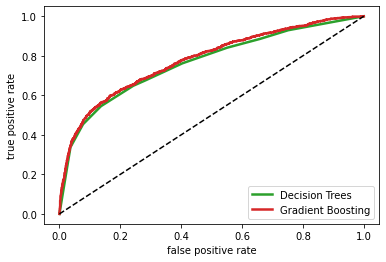

In [309]:
#ROC graph
fpr_best_model_2, tpr_best_model_2, _ = roc_curve(y_val, dt_val_pred_given_score)
fpr_best_model_3, tpr_best_model_3, _ = roc_curve(y_val, gb_val_pred_undersampling_score)

fig, axis = plt.subplots()

axis.plot(fpr_best_model_2, tpr_best_model_2, linewidth=2.5,  color='C2' )
axis.plot(fpr_best_model_3, tpr_best_model_3, linewidth=2.5,  color='C3')

axis.legend(['Decision Trees', 'Gradient Boosting'], loc='lower right')

axis.plot([0, 1], [0,1], 'k--')
axis.set_xlabel('false positive rate')
axis.set_ylabel('true positive rate')
plt.savefig('outputROC.pdf', dpi=300, bbox_inches='tight')
plt.show()

For the precision-recall curve,

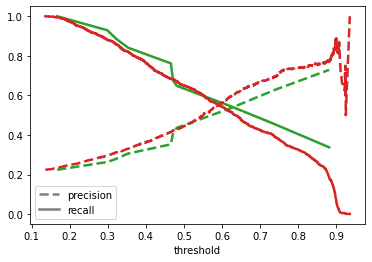

In [310]:
#Precision/recall curve
precision_best_model_2, recall_best_model_2, thresholds_best_model_2 = precision_recall_curve(y_val, dt_val_pred_given_score)
precision_best_model_3, recall_best_model_3, thresholds_best_model_3 = precision_recall_curve(y_val, gb_val_pred_undersampling_score)

fig, axis = plt.subplots()

axis.plot(thresholds_best_model_2, precision_best_model_2[:-1], '--', color='C2', linewidth=2.5,  label='precision')
axis.plot(thresholds_best_model_2, recall_best_model_2[:-1], color='C2' ,linewidth=2.5 ,  label='recall')

axis.plot(thresholds_best_model_3, precision_best_model_3[:-1], '--',linewidth=2.5,  color='C3')
axis.plot(thresholds_best_model_3, recall_best_model_3[:-1],linewidth=2.5,  color='C3')


leg=plt.legend(loc="lower left" )
leg.legendHandles[0].set_color('gray')
leg.legendHandles[1].set_color('gray')

axis.set_xlabel('threshold')
plt.savefig('outputACCURACY.pdf', dpi=300, bbox_inches='tight')
plt.show()

To compute the confusion matrices for the best 3 models,

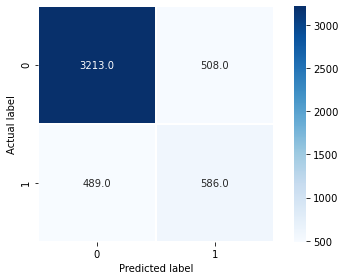

In [311]:
confusion_matrix_best_model_1 = confusion_matrix( y_val , dt_val_pred_given )
sns.heatmap(confusion_matrix_best_model_1,  cmap='Blues',
    square=True, linewidths=0.5,  annot=True, fmt=".1f", 
            xticklabels = ['0', '1'], 
            yticklabels = ['0', '1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confmatrix_DT.pdf', dpi=300, bbox_inches='tight')
plt.show()

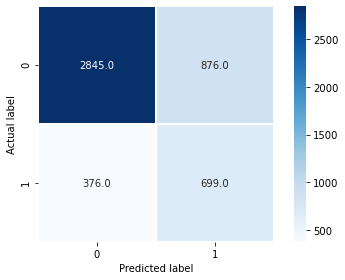

In [312]:
confusion_matrix_best_model_2 = confusion_matrix( y_val , gb_val_pred_undersampling )
sns.heatmap(confusion_matrix_best_model_2,  cmap='Blues',
    square=True, linewidths=0.5,  annot=True, fmt=".1f", 
            xticklabels = ['0', '1'], 
            yticklabels = ['0', '1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confmatrix_GB.pdf', dpi=300, bbox_inches='tight')
plt.show()

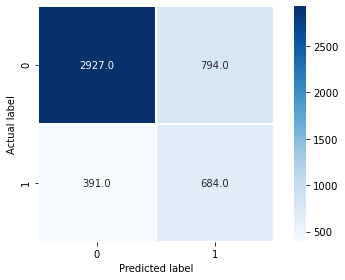

In [313]:
with torch.no_grad():
        outputs = net_over(x_val)
        pred = np.round(outputs.numpy()[:])
nn_pred = pred.astype('int')[:,0]
nn_pred[nn_pred==2] = 1 # There are some labels which are above and below the range so we just add them to the correct class as there are only 1 or 2 so they won't affect the results much but they will break the code
nn_pred[nn_pred==-1] = 0
confusion_matrix_best_model_2 = confusion_matrix( y_val , nn_pred)
sns.heatmap(confusion_matrix_best_model_2,  cmap='Blues',
    square=True, linewidths=0.5,  annot=True, fmt=".1f", 
            xticklabels = ['0', '1'], 
            yticklabels = ['0', '1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confmatrix_NN.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [314]:
#used to plot the metric graph,
# DT:
DT_res = get_results(y_val, dt_val_pred_given).to_numpy()*100
# GB: 
GB_res = get_results(y_val, gb_val_pred_undersampling).to_numpy()*100
# NN:
NN_res = get_results(y_val, nn_pred).to_numpy()*100

<Figure size 432x288 with 0 Axes>

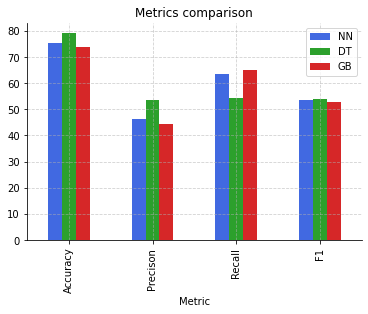

In [315]:
plt.figure()


data=[["Accuracy",NN_res[0,0],DT_res[0,0],GB_res[0,0]],
      ['Precison',NN_res[0,1],DT_res[0,1],GB_res[0,1]],
      ["Recall",NN_res[0,2],DT_res[0,2],GB_res[0,2]],
      ["F1",NN_res[0,3],DT_res[0,3],GB_res[0,3]],
     ]
      
df = pd.DataFrame(data,columns=['Metric',"NN","DT","GB"])
df.plot(x="Metric", y=["NN", "DT", "GB"], kind="bar",color=['royalblue', 'C2', 'C3', 'C5' ])
plt.title('Metrics comparison')
plt.grid(linestyle = '--',alpha = 0.6)
ax1 = plt.subplot(1,1,1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.savefig('Metrics_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Final Predictions on Test Set

For DTs,

In [316]:
dt_given_test = dt_given.predict(X_test_given)
get_results(y_test, dt_given_test)

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0              0.747   0.432403  0.636651  0.515016  0.706581

For Gradient Boosting,

In [317]:
gb_test_pred_undersampling = gb_undersampling.predict(X_test_undersampling)
get_results(y_test, gb_test_pred_undersampling)

Balanced Accuracy  Precision    Recall  F1 Score       ROC
0           0.757833   0.449866  0.662717  0.535931  0.722994

For NN,

In [318]:
with torch.no_grad():
        outputs = net_over(x_test)
        pred = np.round(outputs.numpy()[:])
nn_pred = pred.astype('int')[:,0]
nn_pred[nn_pred==2] = 1
nn_pred[nn_pred==-1] = 0
get_results(y_test, nn_pred)

Balanced Accuracy  Precision   Recall  F1 Score       ROC
0           0.760667    0.45262  0.64139  0.530719  0.716977

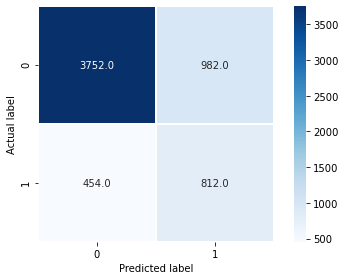

In [319]:
with torch.no_grad():
        outputs = net_over(x_test)
        pred = np.round(outputs.numpy()[:])
nn_pred = pred.astype('int')[:,0]
nn_pred[nn_pred==2] = 1 # There are some labels which are above and below the range so we just add them to the correct class as there are only 1 or 2 so they won't affect the results much but they will break the code
nn_pred[nn_pred==-1] = 0
confusion_matrix_best_model_2 = confusion_matrix( y_test , nn_pred)
sns.heatmap(confusion_matrix_best_model_2,  cmap='Blues',
    square=True, linewidths=0.5,  annot=True, fmt=".1f", 
            xticklabels = ['0', '1'], 
            yticklabels = ['0', '1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confmatrix_NN_test.pdf', dpi=300, bbox_inches='tight')
plt.show()